In [1]:
from functions import *

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

### Project leboiron linestrings into points

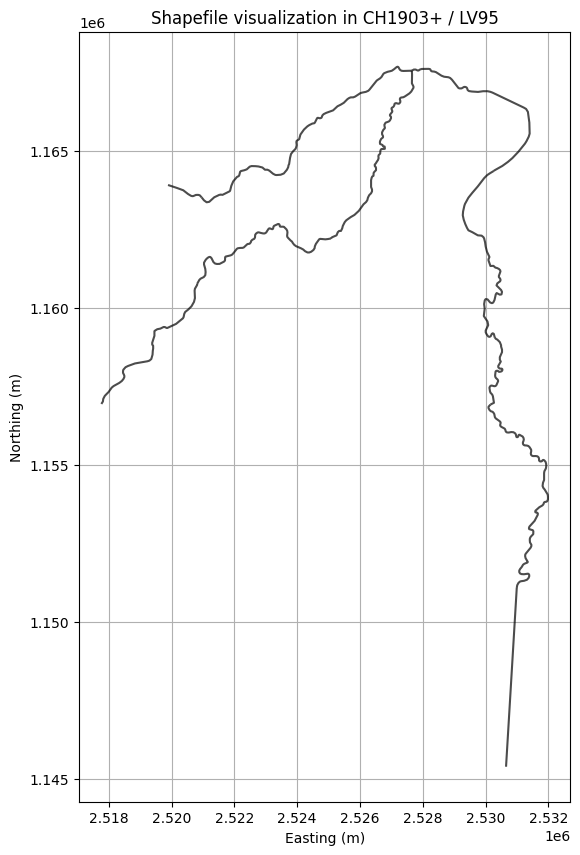

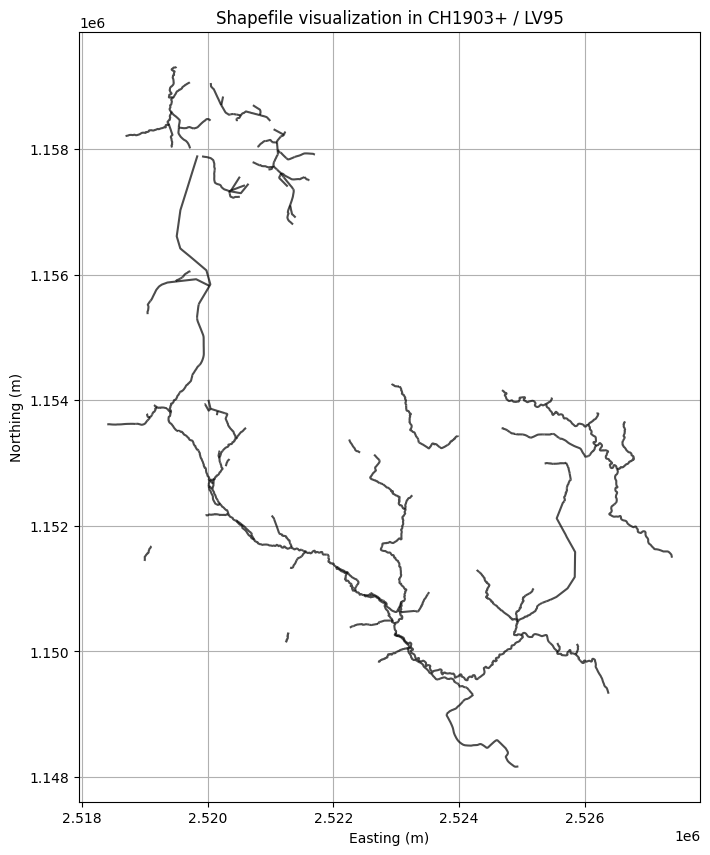

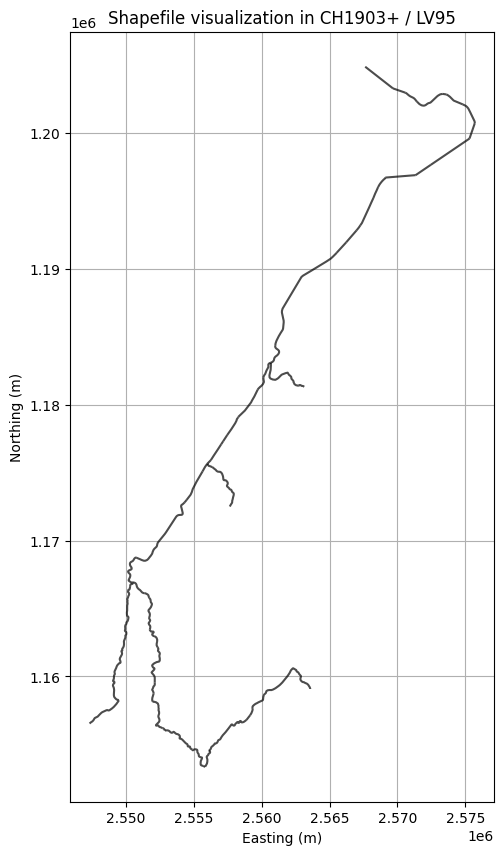

In [3]:
source_folder = '../data/external/shp/rivers/'
#source_folder = '../data/external/shp/rivers/swissTLMboiron/'

rivers = {}
for subdir, dirs, files in os.walk(source_folder):
    if len(dirs) == 0:
        river = gpd.read_file(subdir)

        # Filter out the outliers
        gdf = river
        centroid = gdf.unary_union.centroid
        gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)
        if subdir.split('/')[-1] == 'LaBroye_shapefile':
            threshold_distance = gdf['distance_to_centroid'].quantile(0.99)
            river = gdf[gdf['distance_to_centroid'] <= threshold_distance]
        elif subdir.split('/')[-1] == 'LaVenoge_shapefile':
            threshold_distance = gdf['distance_to_centroid'].quantile(0.9)
            river = gdf[gdf['distance_to_centroid'] <= threshold_distance]
        
        rivers[subdir.split('/')[-1]] = river

        fig, ax = plt.subplots(figsize=(10, 10))
        river.plot(ax=ax, edgecolor='k', alpha=0.7)
        ax.set_title('Shapefile visualization in CH1903+ / LV95')
        plt.xlabel('Easting (m)')
        plt.ylabel('Northing (m)')
        plt.grid(True)
        plt.show()

## Air interpolation

In [22]:
start_date = '2011-01-01'
end_date = '2019-12-31'

fent 


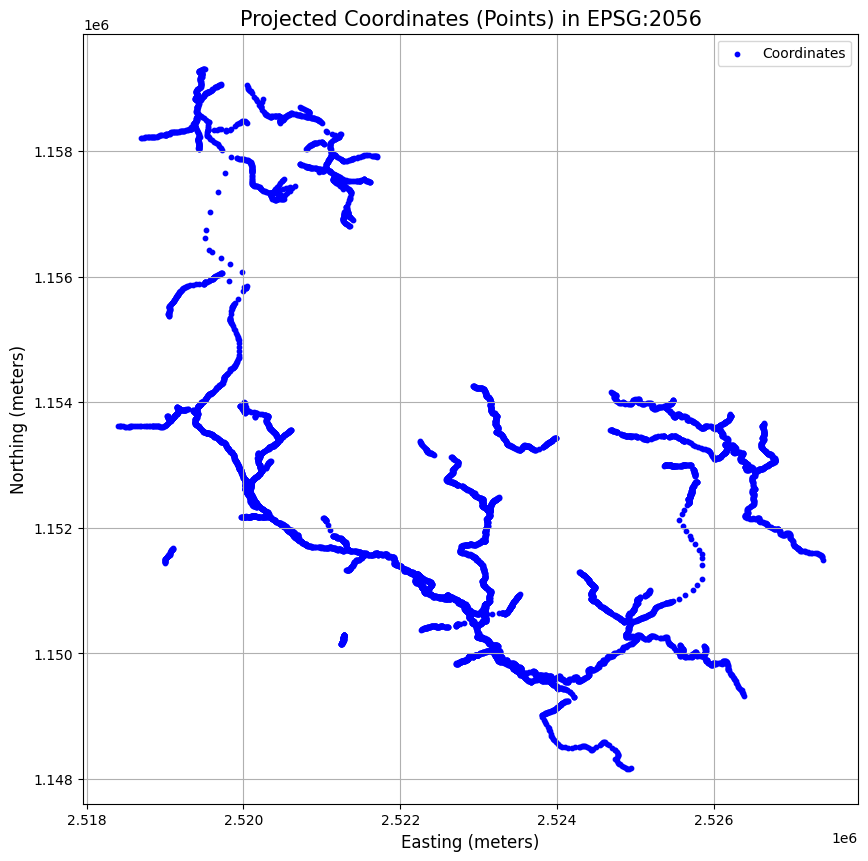

In [24]:
PATH_DATA = '../data/external/'
for k,river in rivers.items():
    print('fent',k)
    x_coords, y_coords, z_coords = project_linestrings_to_points(river)
    projection_coordenates = pd.DataFrame(data={'Coord X': x_coords,'Coord Y': y_coords,'Altitude': z_coords})
    
    air_stations_total_data = pd.read_csv(os.path.join(PATH_DATA, 'airtemp files/30MinFreq_air_boiron_and_swissmeteo_data.csv'),index_col=0)
    air_stations_total_metadata = pd.read_csv(os.path.join(PATH_DATA, 'airtemp files/air_boiron_and_swissmeteo_metadata.csv'),index_col=0)
    
    # Filter the data to the selected time period
    air_stations_filt = air_stations_total_data.loc[start_date:end_date]
    air_stations_filt.index = pd.to_datetime(air_stations_filt.index)
    air_stations_monthly_mean = air_stations_filt.resample('M').mean()

    # Interpolate the data
    LR = 5.5
    air_interpolated = pd.DataFrame(columns=projection_coordenates.index)

    for ri,r in air_stations_monthly_mean.iterrows():
        temp = pd.concat([pd.DataFrame(r.values, index=r.index, columns=['temp',]), air_stations_total_metadata], axis=1)
        temp.dropna(inplace=True)

        temp['temp'] += LR * temp['Altitude'] / 1000

        if len(temp) == 0:
            a = np.empty(projection_coordenates.shape[0])
            a[:] = np.nan
            air_interpolated.loc[ri] = a
        else:
            x = temp['Coord X']
            y = temp['Coord Y']
            z = temp['temp']

            xi = projection_coordenates['Coord X']
            yi = projection_coordenates['Coord Y']

            temp_interpolated = simple_idw(x, y, z, xi, yi, beta=2)
            temp_interpolated -= LR * projection_coordenates['Altitude']  / 1000

            air_interpolated.loc[ri] = temp_interpolated

    air_interpolated.to_csv(os.path.join(PATH_DATA,'air_interpolated_leboiron.csv'), header=True)

#### Show and save results

In [26]:
# Function to map coordinates to the grid (pre-compute grid indices)
def get_closest_grid_cell(x, y, x_range, y_range):
    x_idx = np.argmin(np.abs(x_range - x))
    y_idx = np.argmin(np.abs(y_range - y))
    return x_idx, y_idx

In [27]:
folder_path = '../data/raw/airtemp_interpolated'

# List all files in the folder and delete them
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    try:
        if os.path.isfile(file_path):
            os.remove(file_path)
    except Exception as e:
        print(f"Error: {e}")


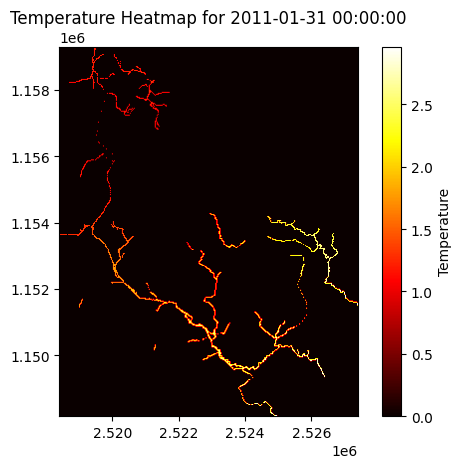

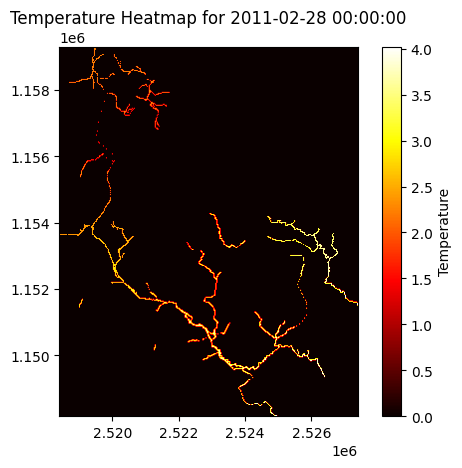

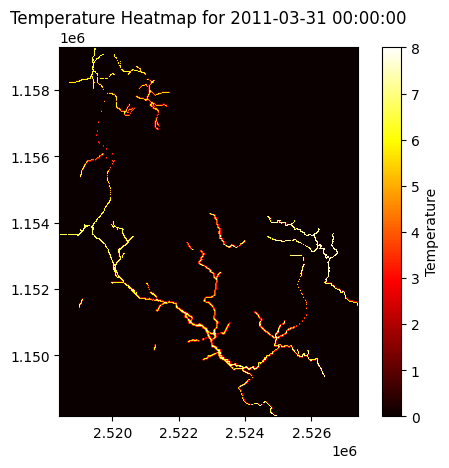

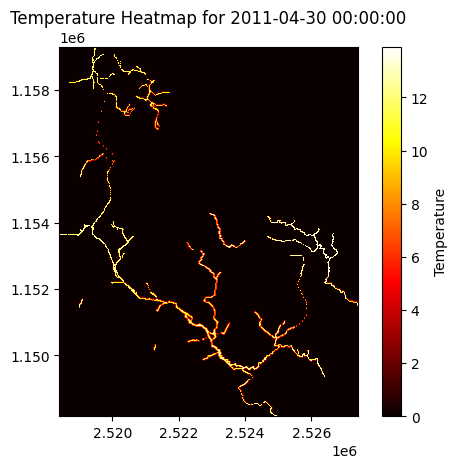

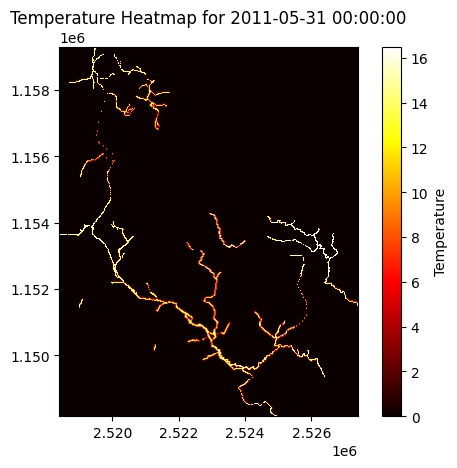

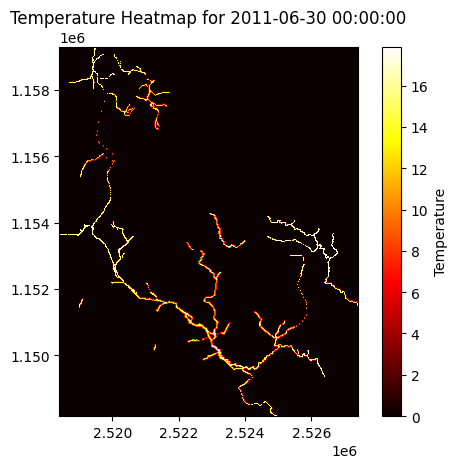

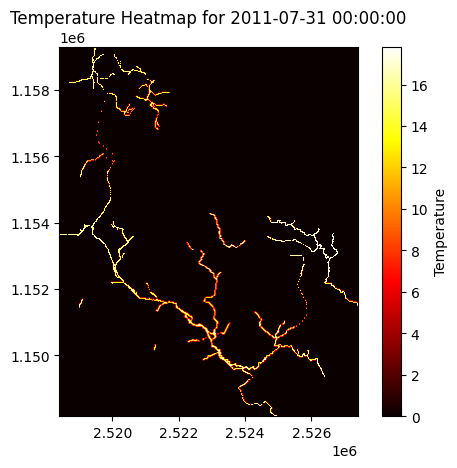

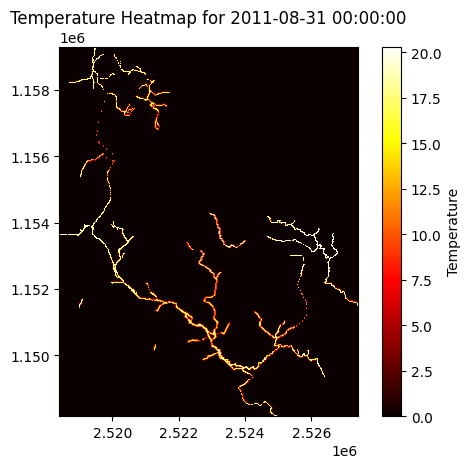

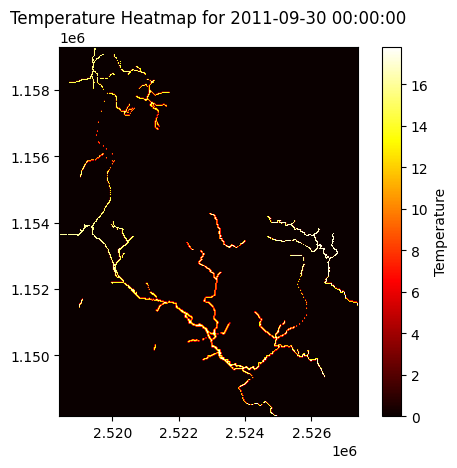

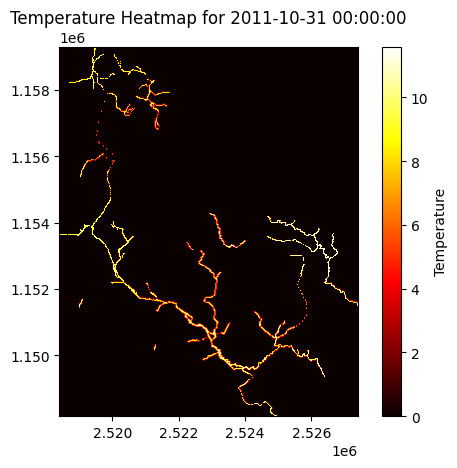

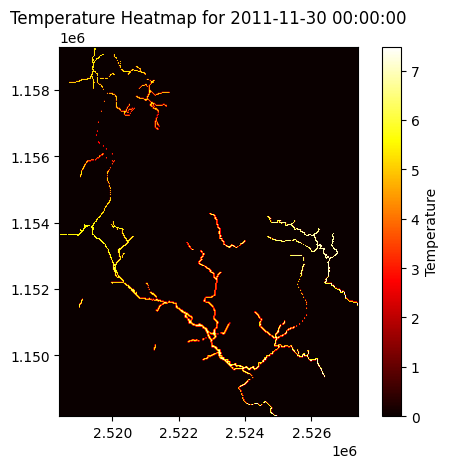

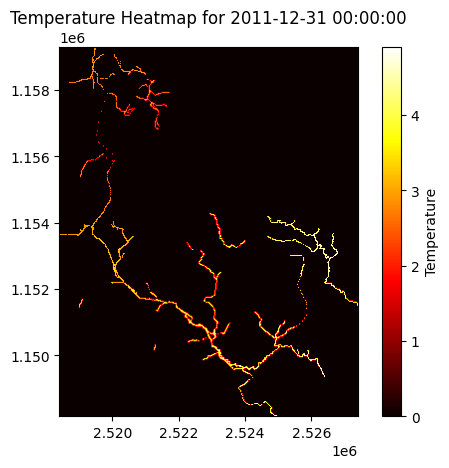

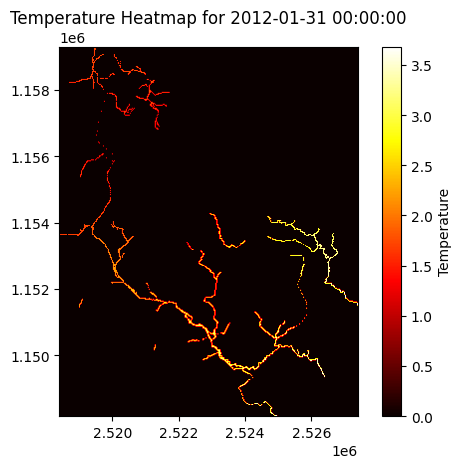

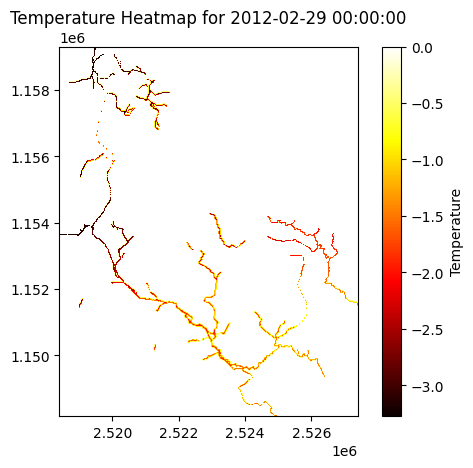

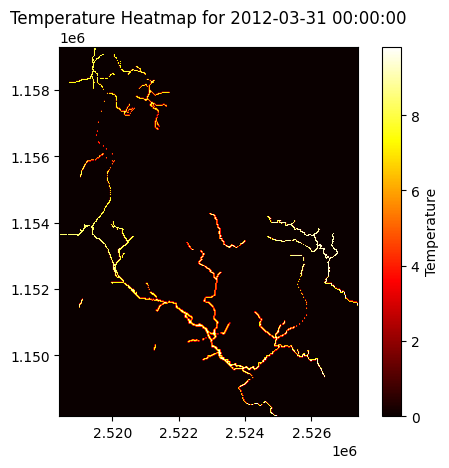

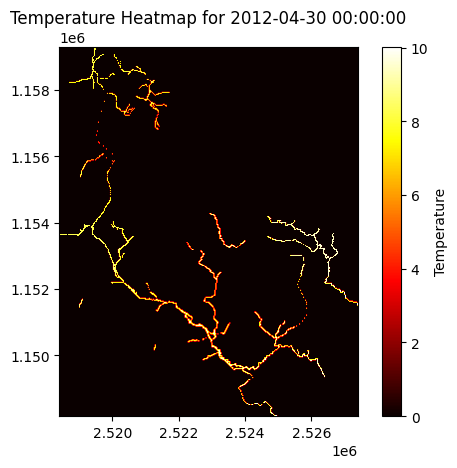

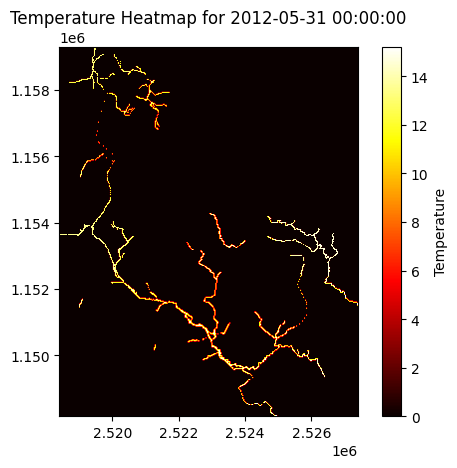

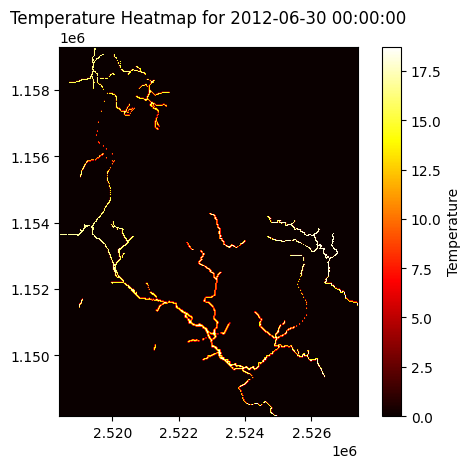

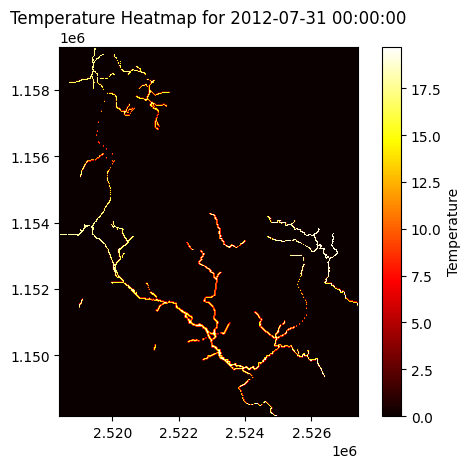

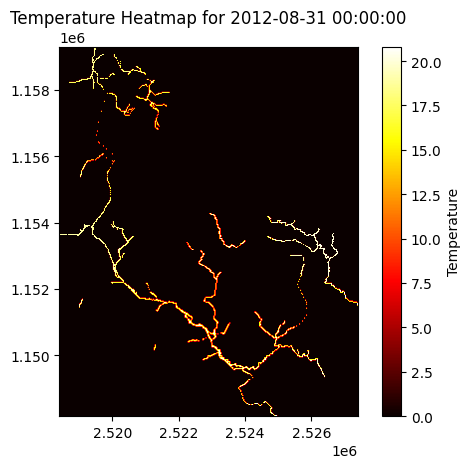

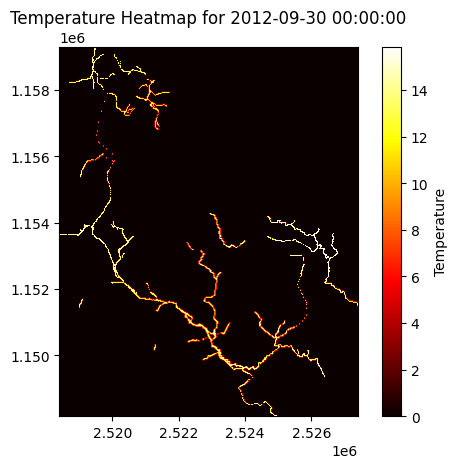

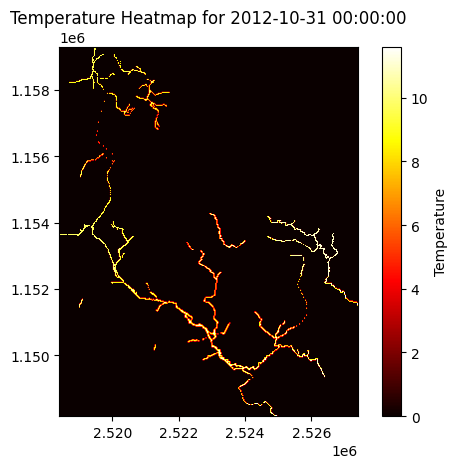

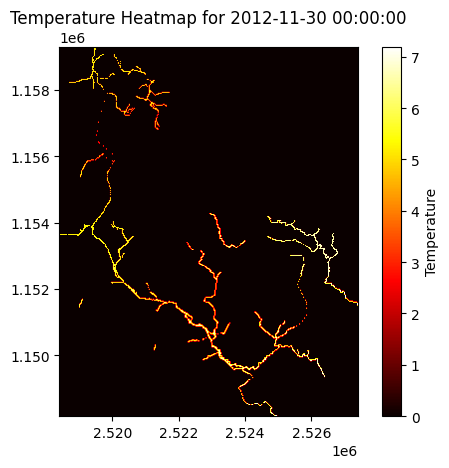

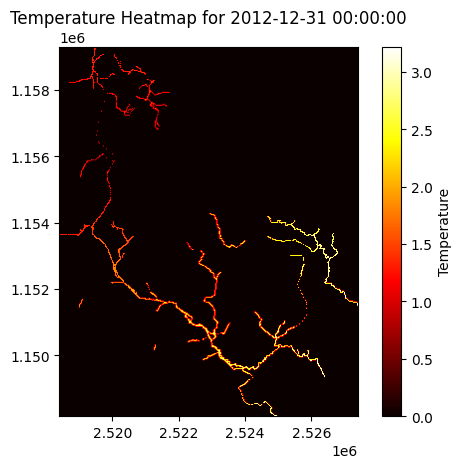

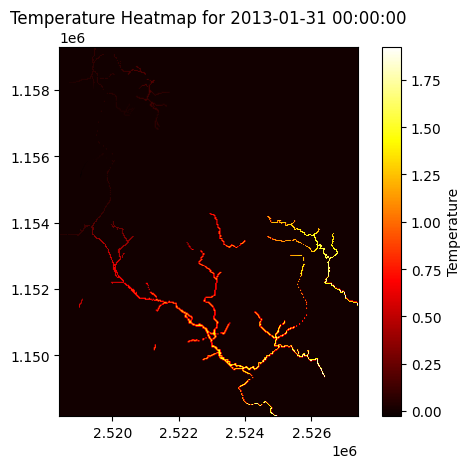

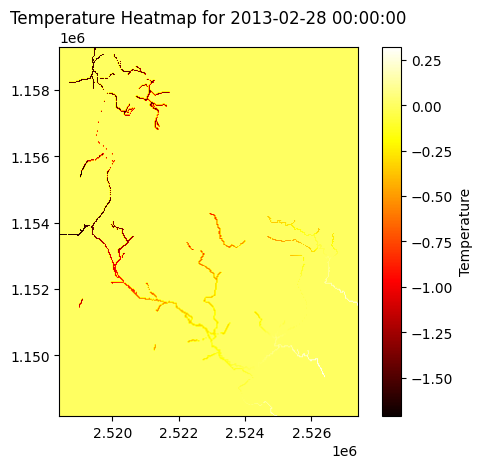

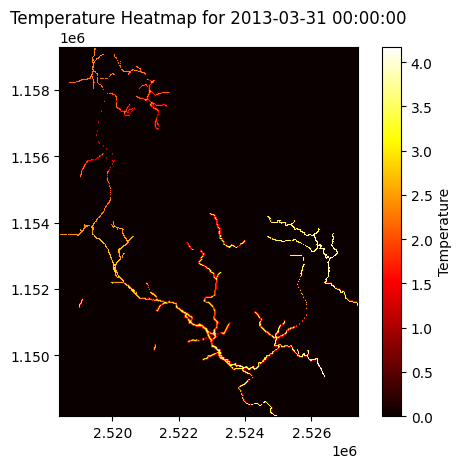

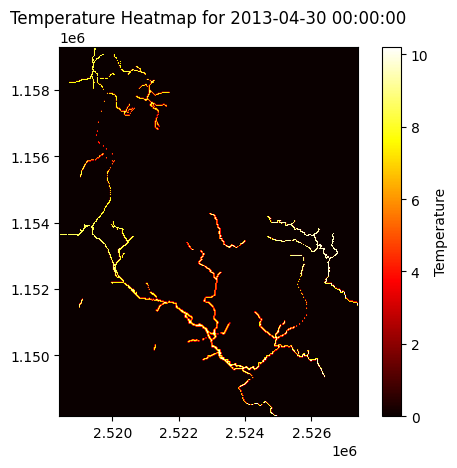

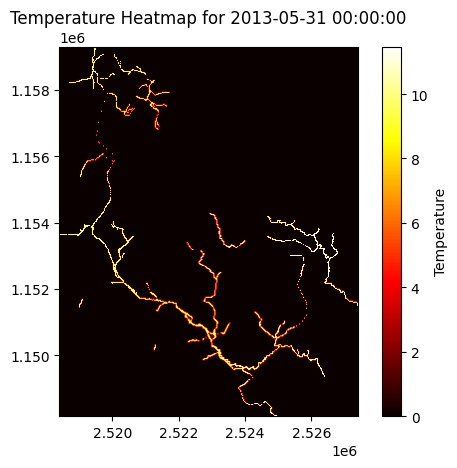

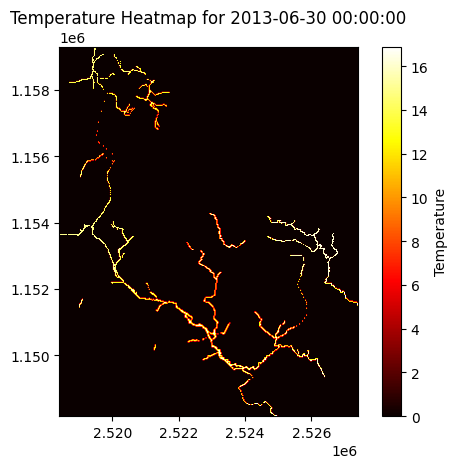

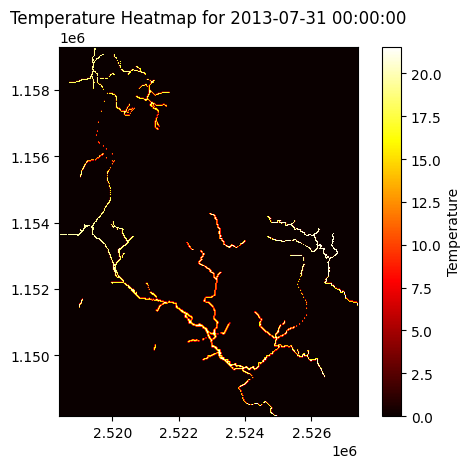

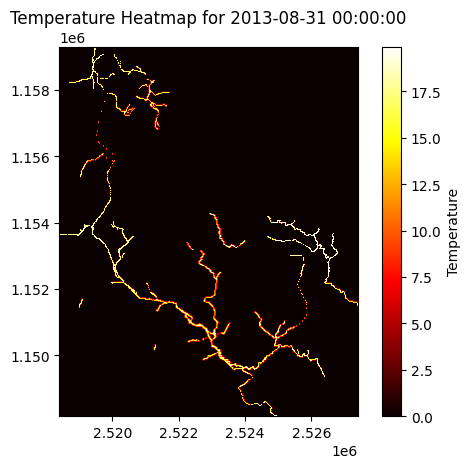

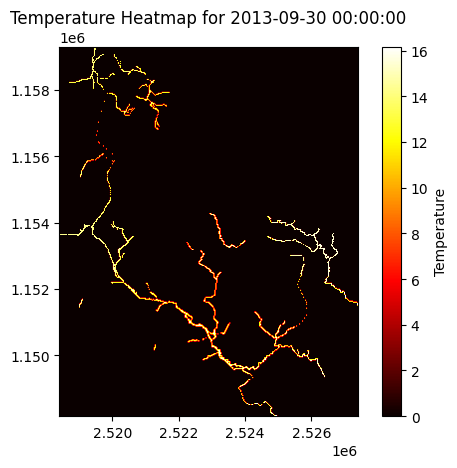

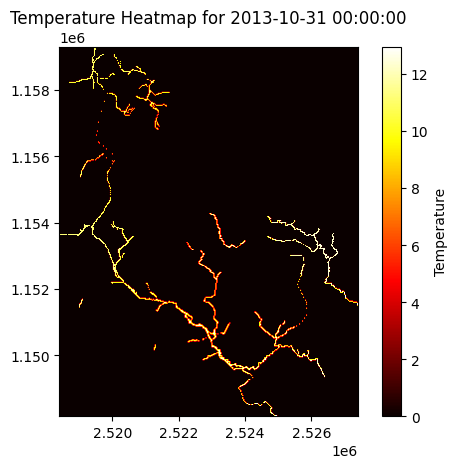

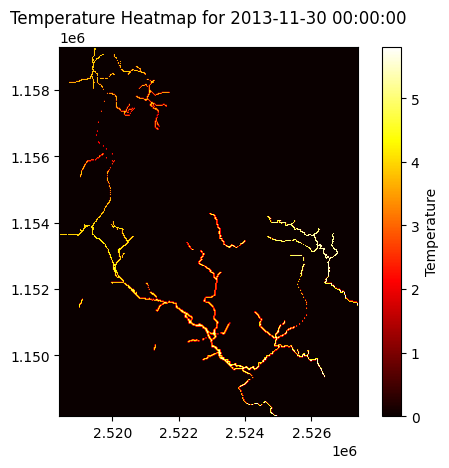

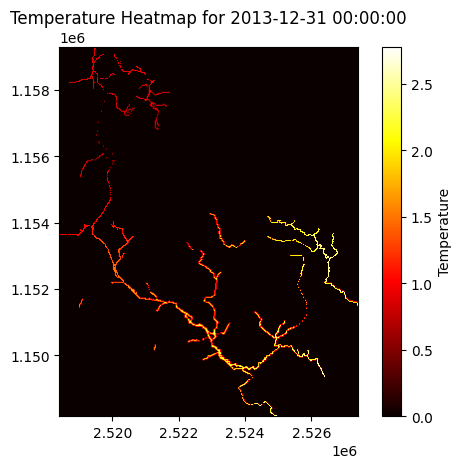

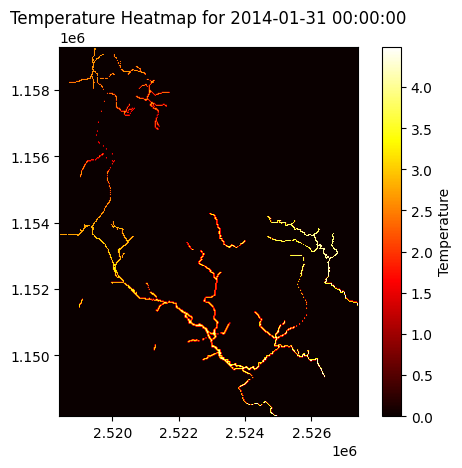

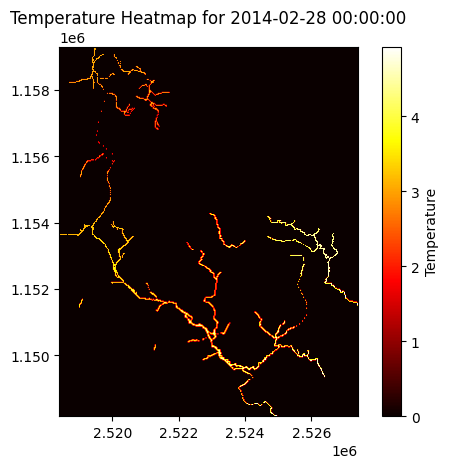

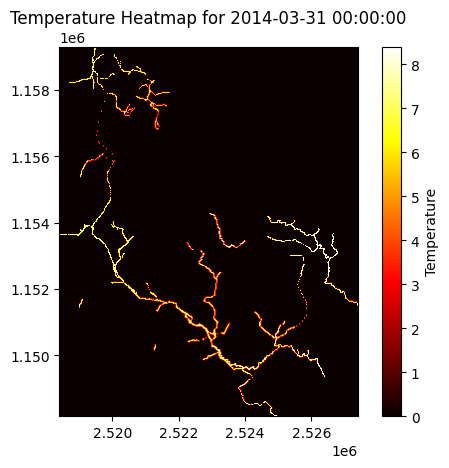

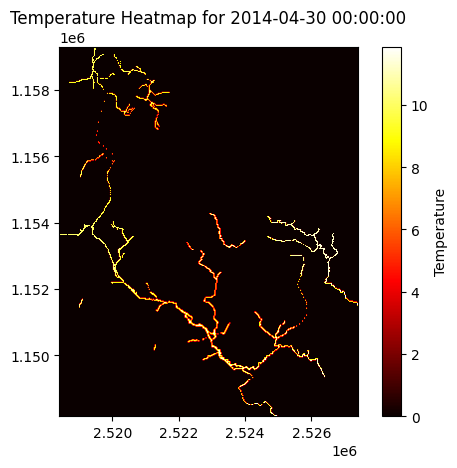

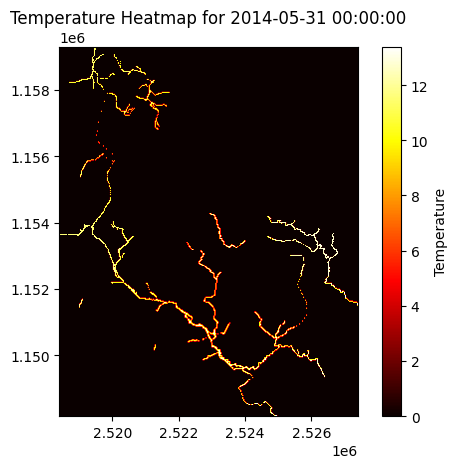

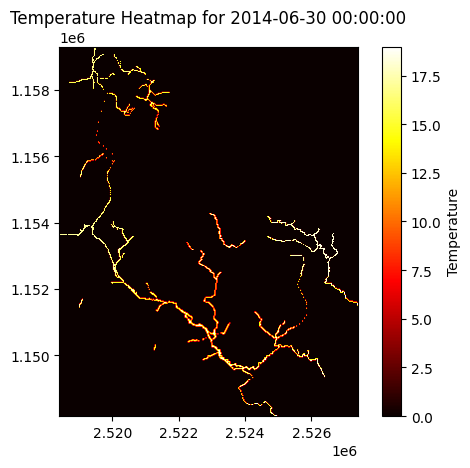

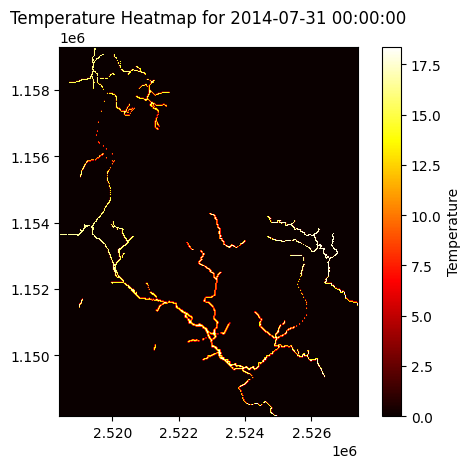

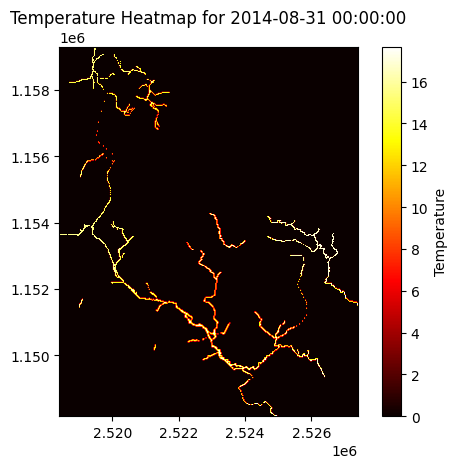

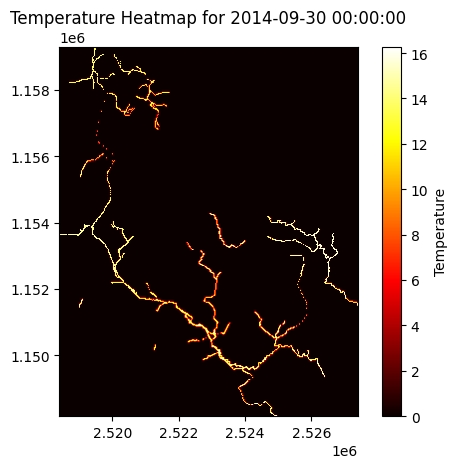

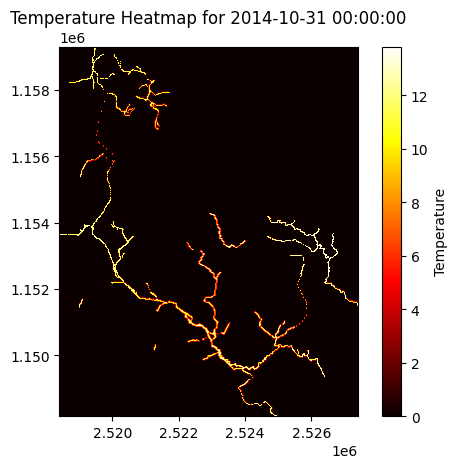

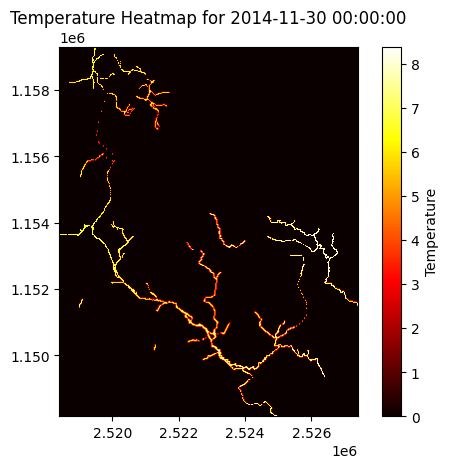

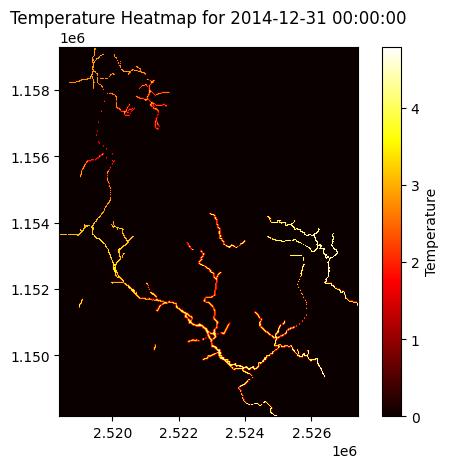

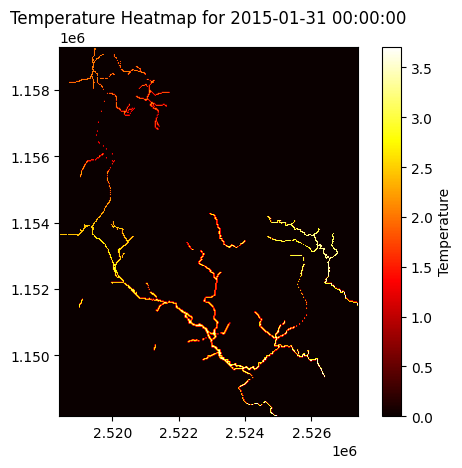

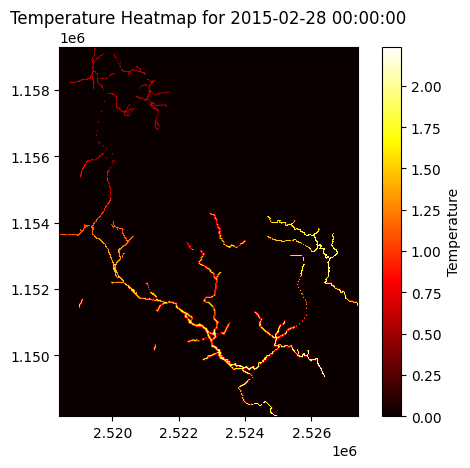

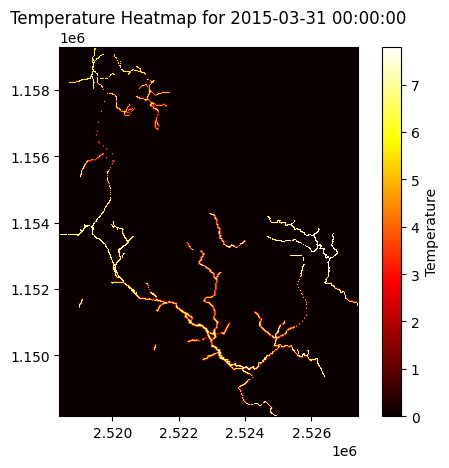

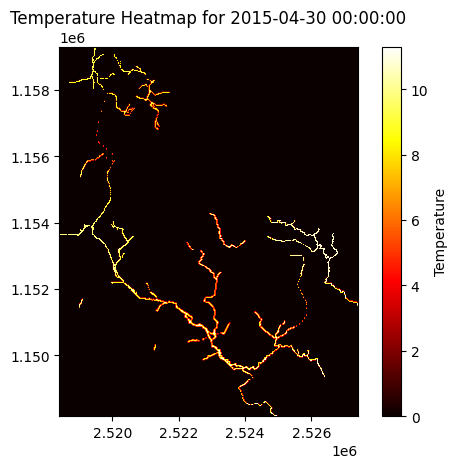

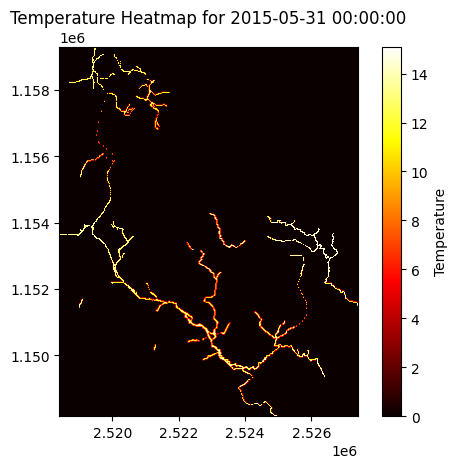

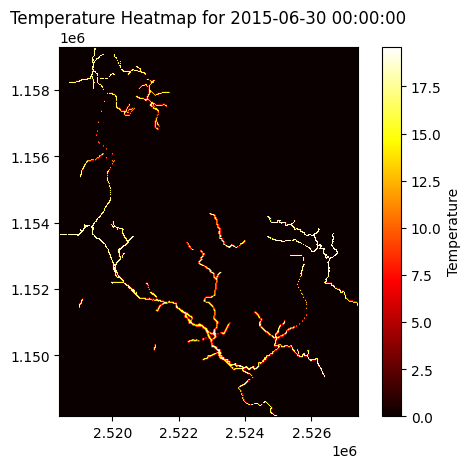

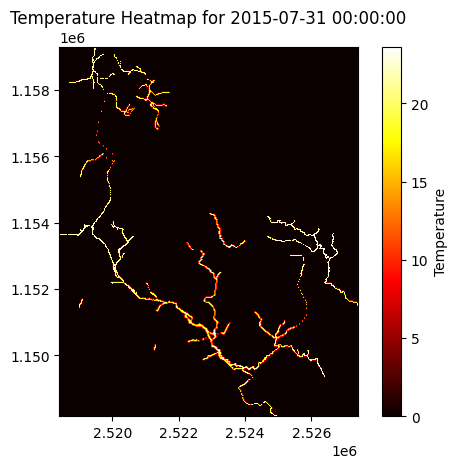

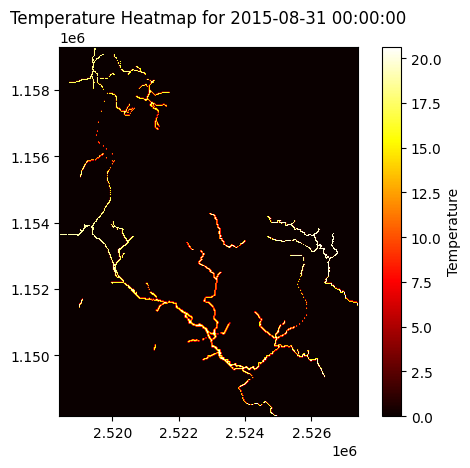

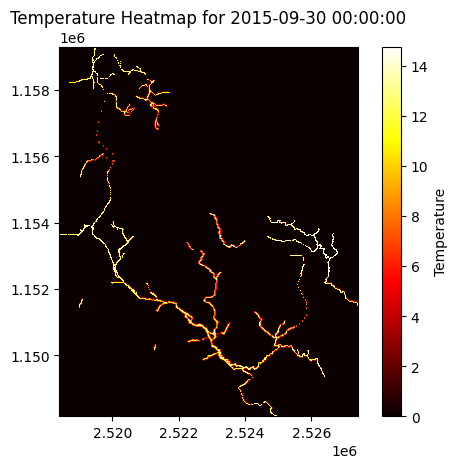

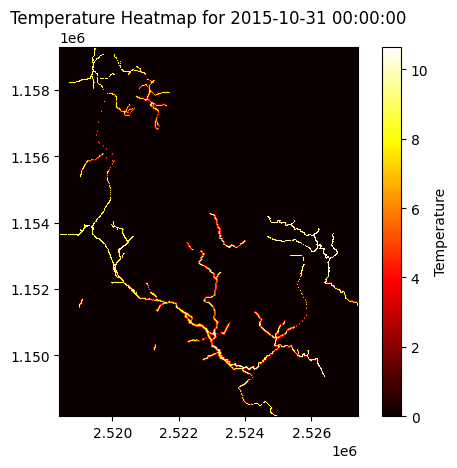

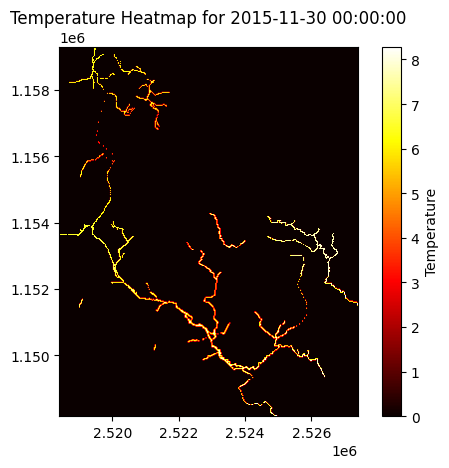

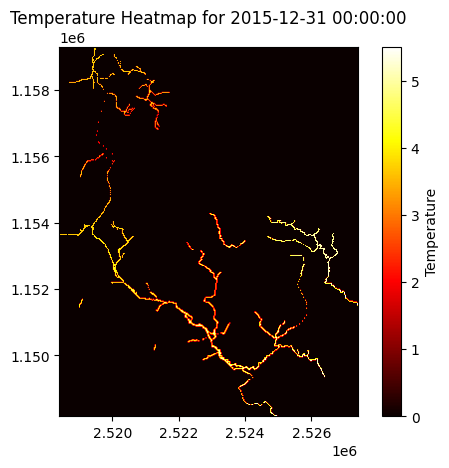

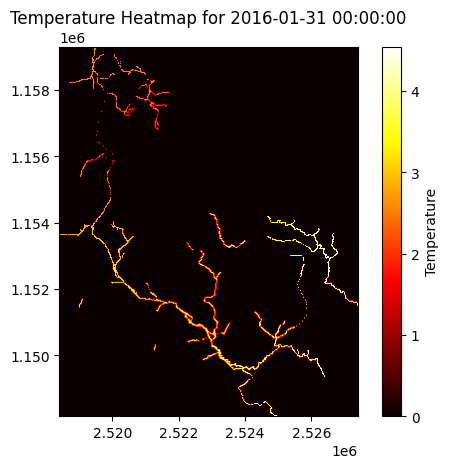

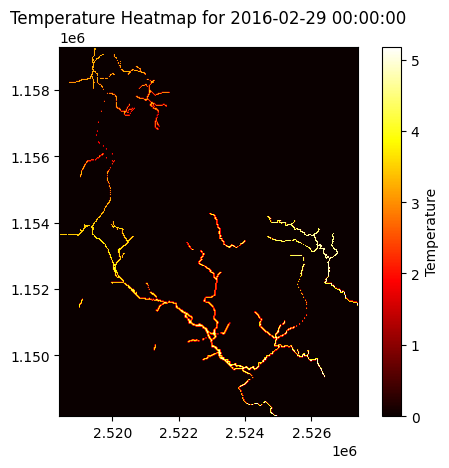

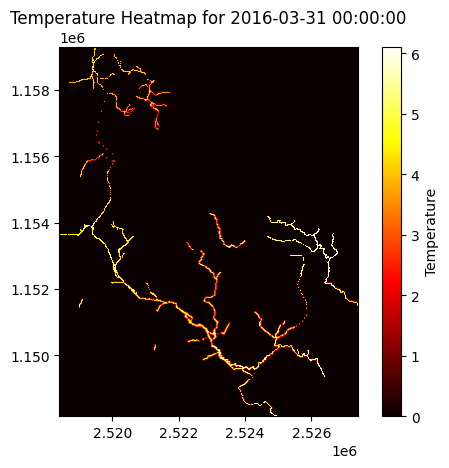

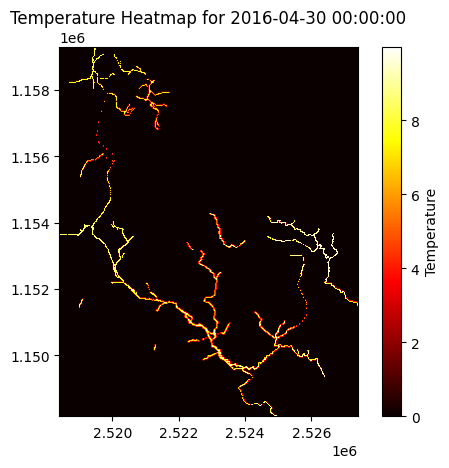

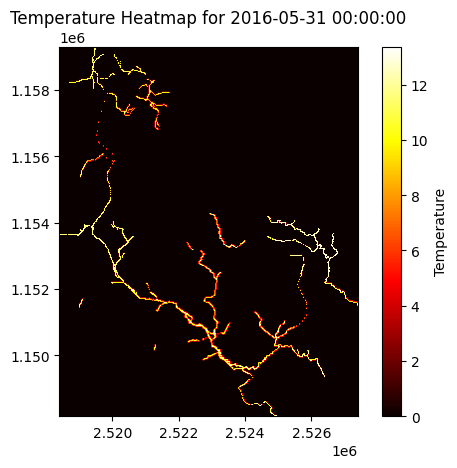

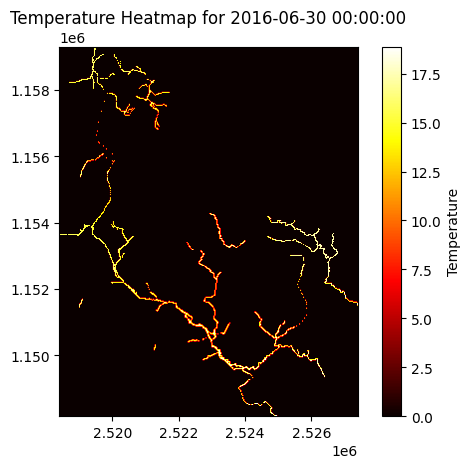

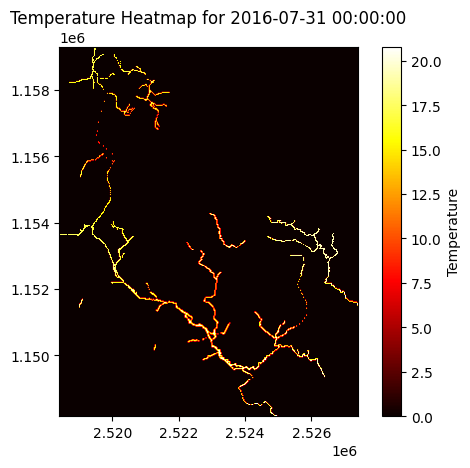

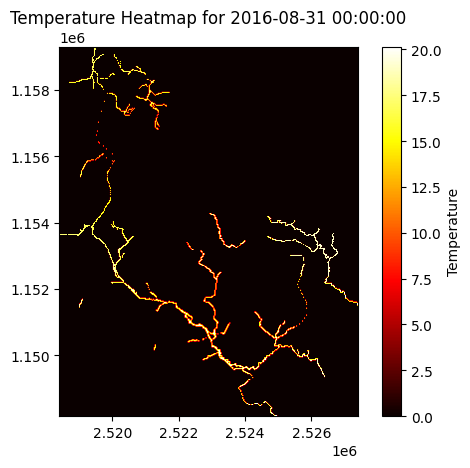

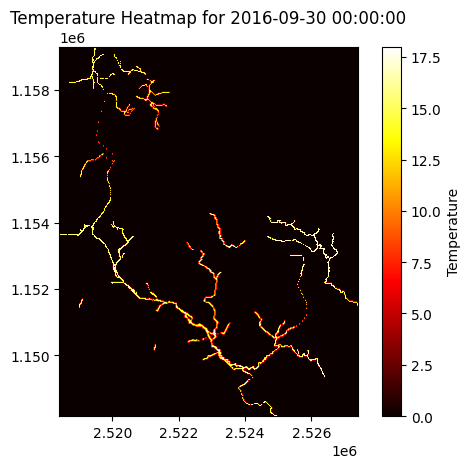

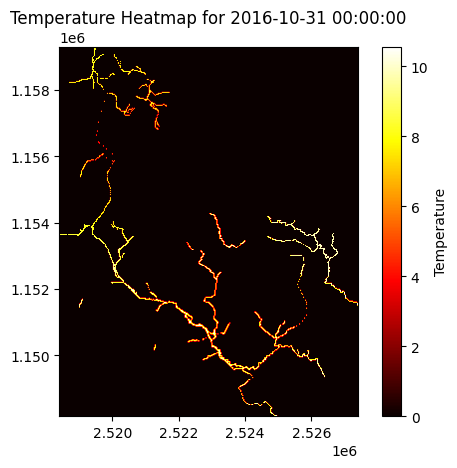

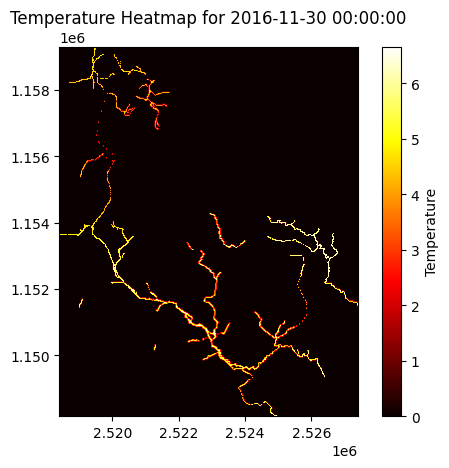

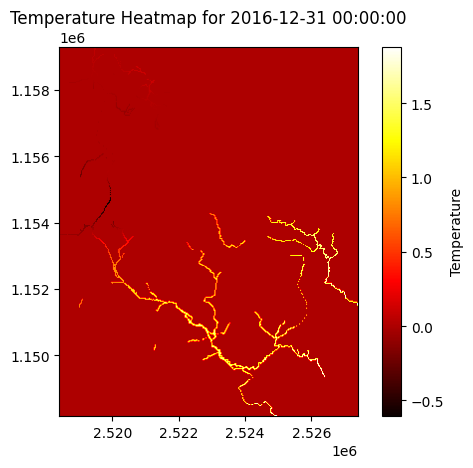

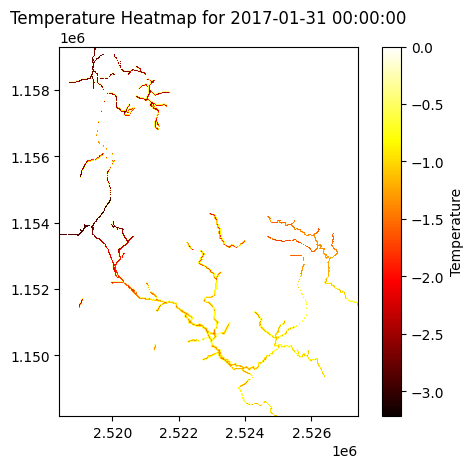

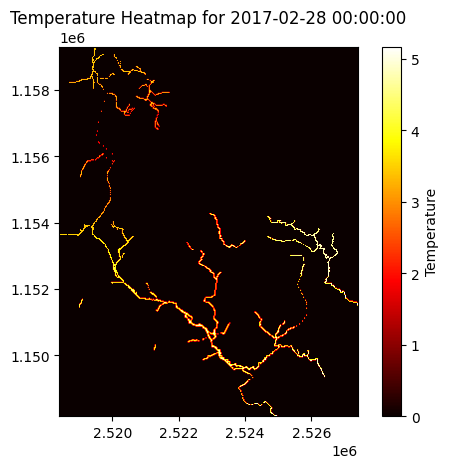

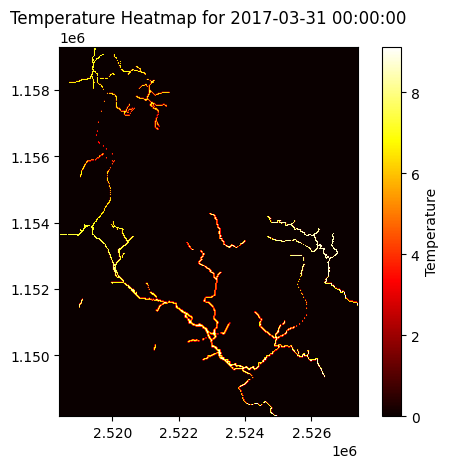

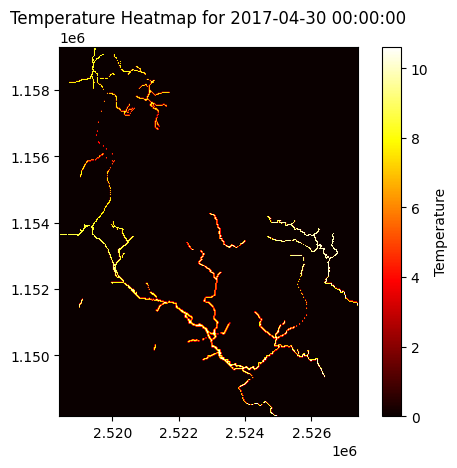

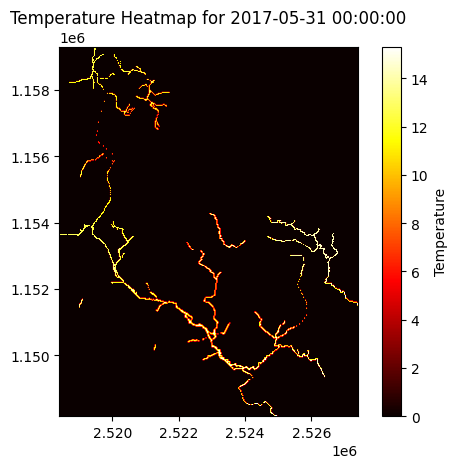

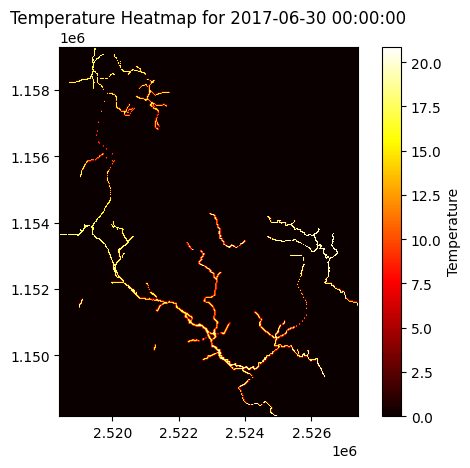

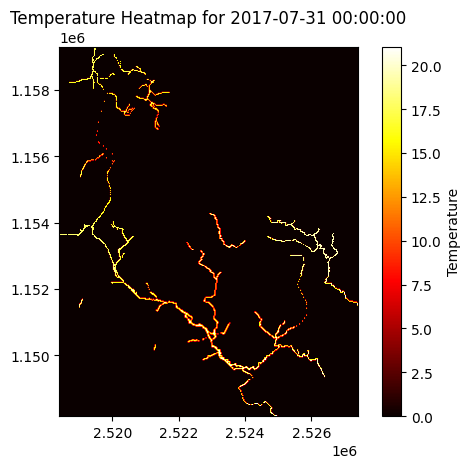

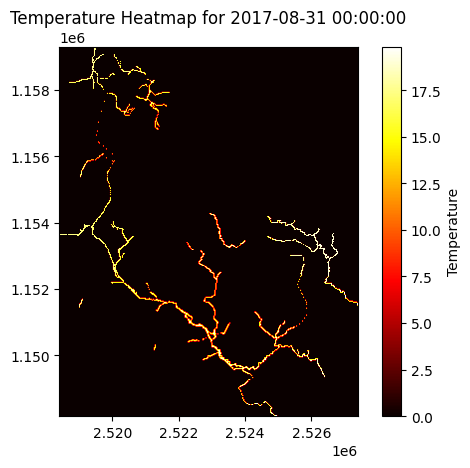

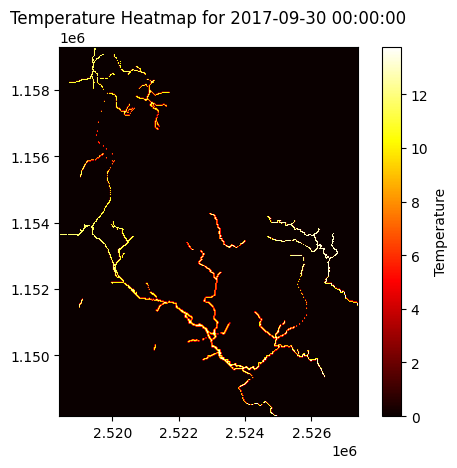

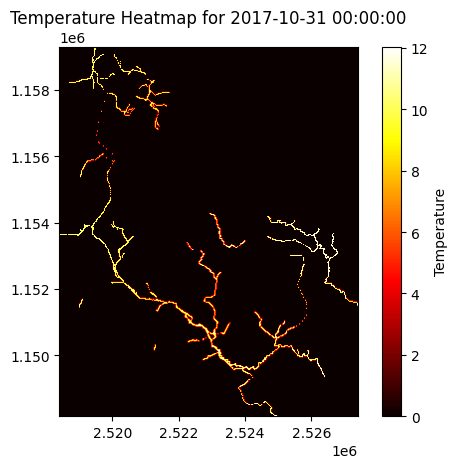

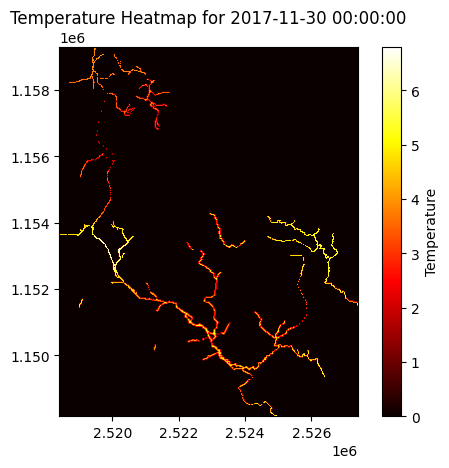

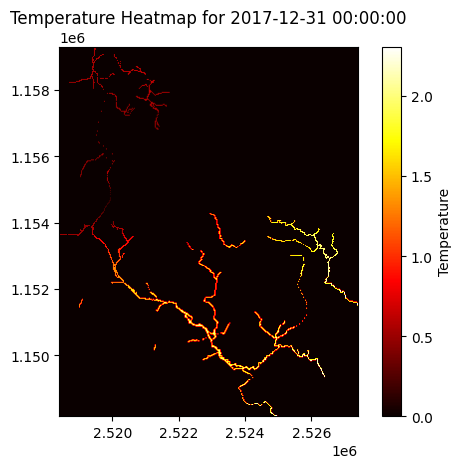

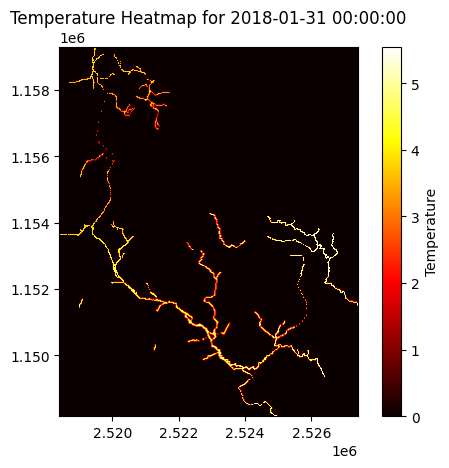

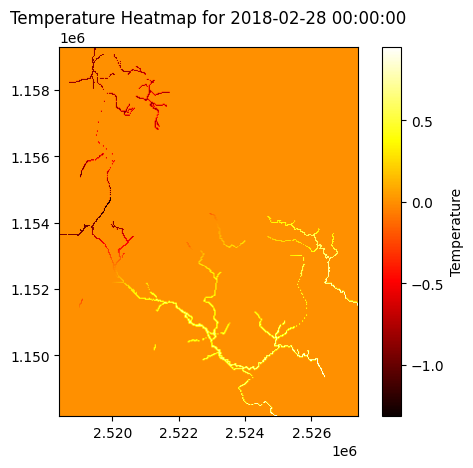

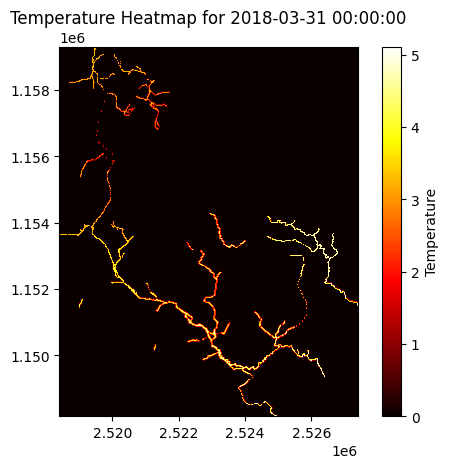

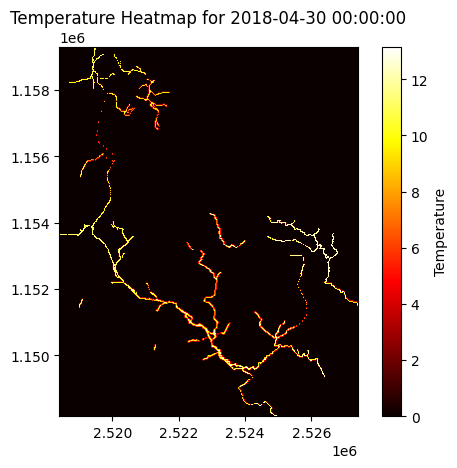

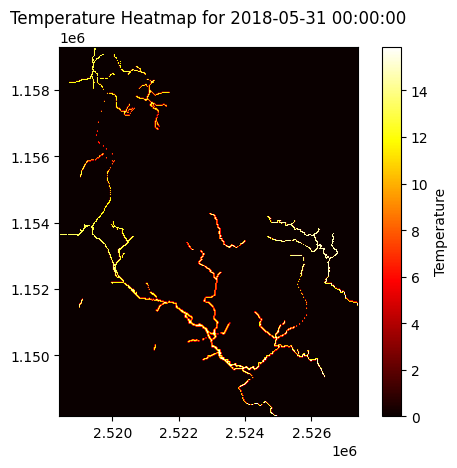

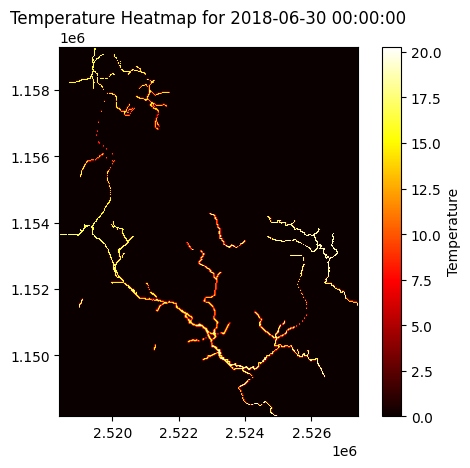

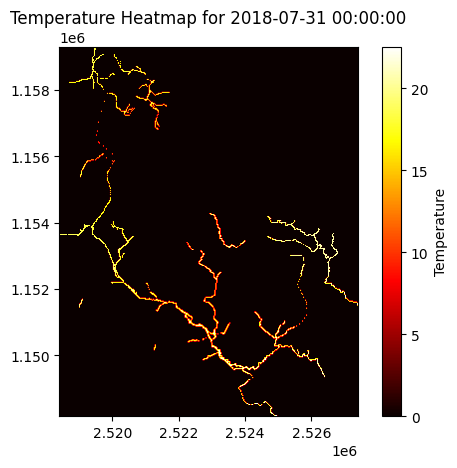

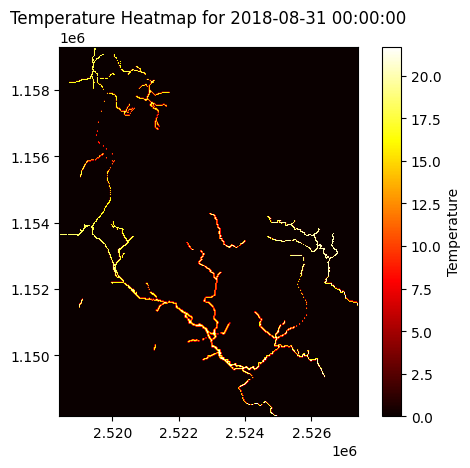

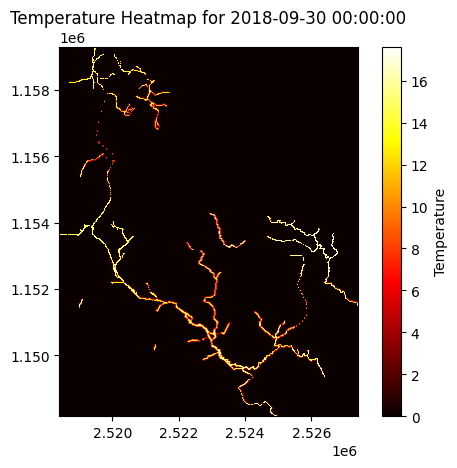

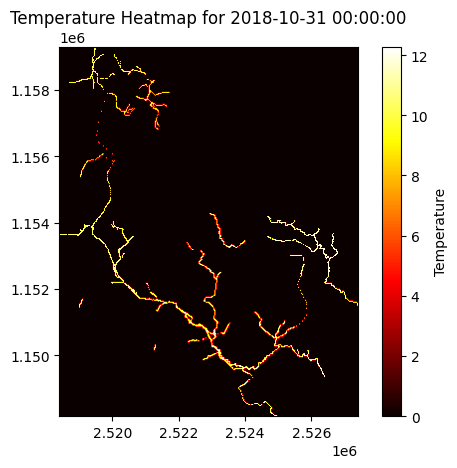

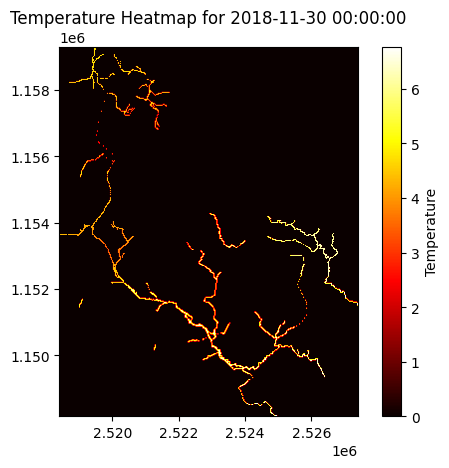

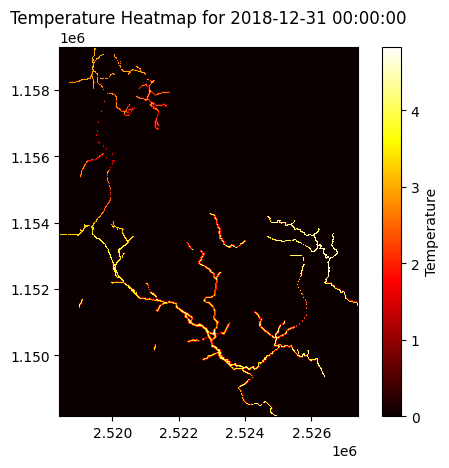

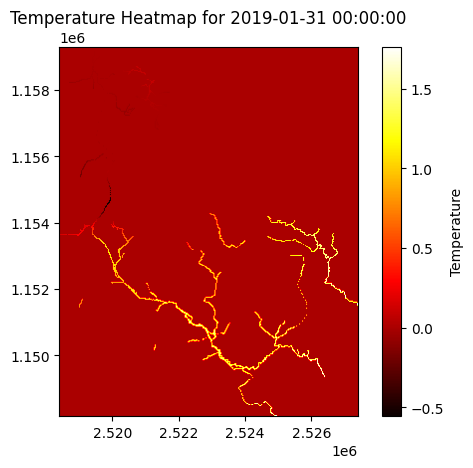

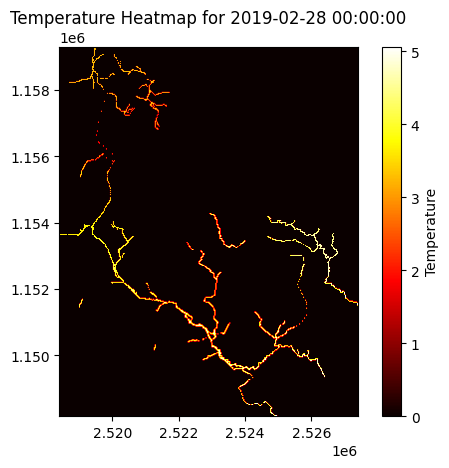

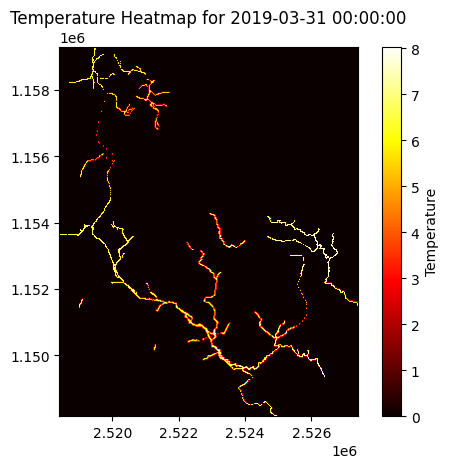

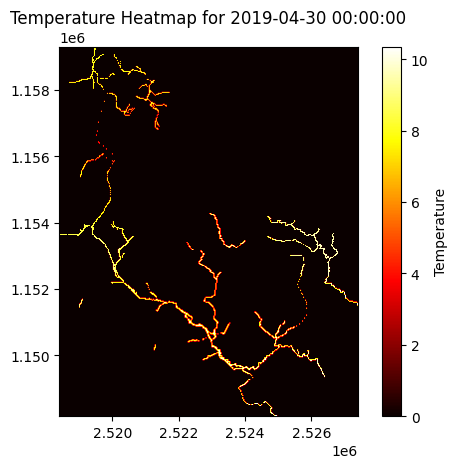

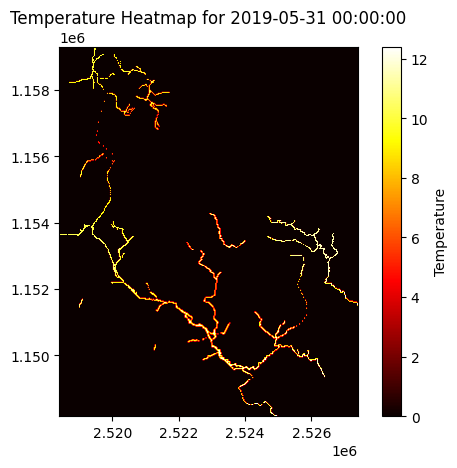

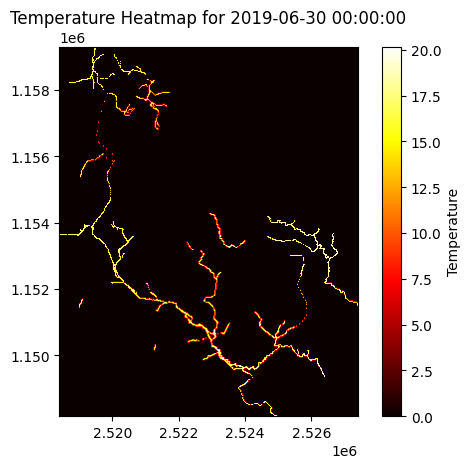

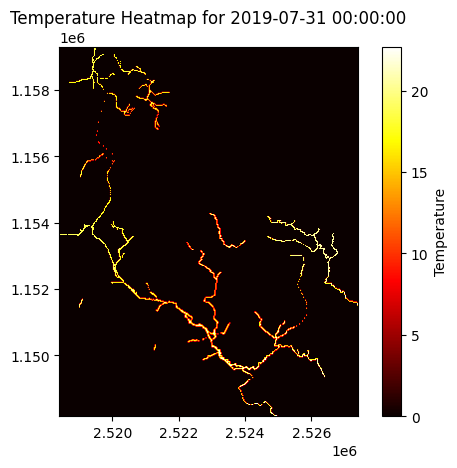

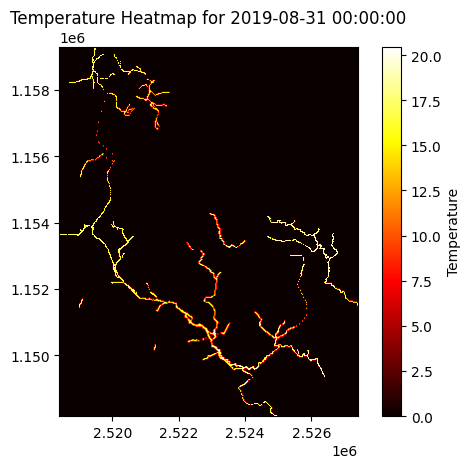

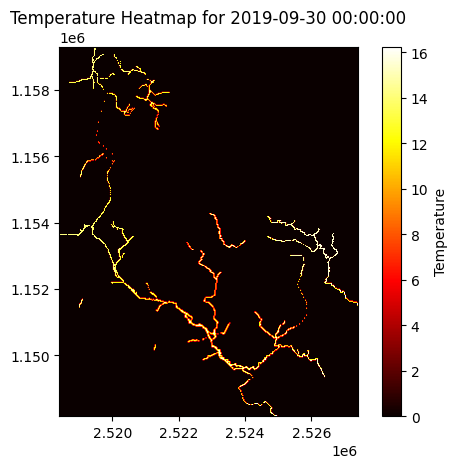

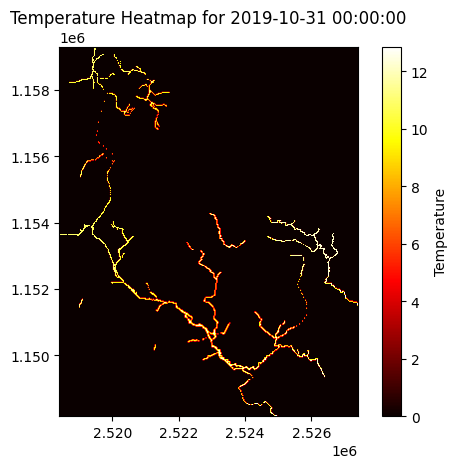

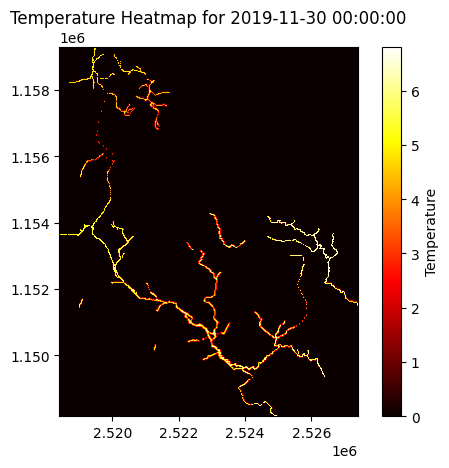

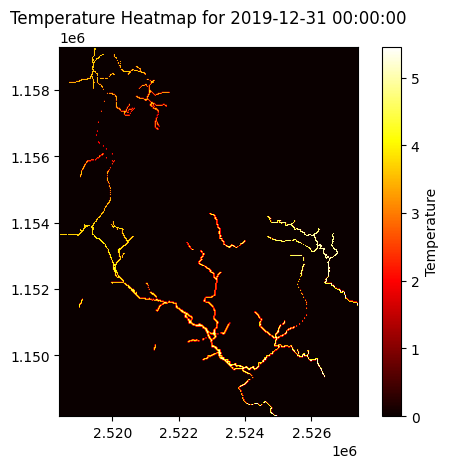

In [28]:
for k,river in rivers.items():
    
    df = projection_coordenates.join(np.transpose(air_interpolated))

    # Extract the coordinate columns (Coord X, Coord Y)
    x_coords = df['Coord X'].values
    y_coords = df['Coord Y'].values

    # Define bounds and resolution for the grid
    bounds = river.total_bounds
    resolution = 30
    x_min, y_min, x_max, y_max = bounds
    x_range = np.arange(x_min, x_max, resolution)
    y_range = np.arange(y_min, y_max, resolution)

    # Precompute the grid cell indices for all coordinates
    grid_indices = [get_closest_grid_cell(x, y, x_range, y_range) for x, y in zip(x_coords, y_coords)]

    # Define the transformation for the raster grid
    transform = from_origin(x_min, y_max, resolution, resolution)

    # Loop through each temperature column (each date)
    for col in df.columns[3:]:  # Assuming temperature columns start from the 4th column onward
        temperature = df[col].values  # Extract the temperature data for the current date

        # Initialize an array to store temperature values for the current day
        raster_array = np.zeros((len(y_range), len(x_range)))

        # Assign temperature values to the grid cells based on precomputed indices
        for i, (x_idx, y_idx) in enumerate(grid_indices):
            temp = temperature[i]
            raster_array[y_idx, x_idx] = temp

        save_raster(np.flipud(raster_array),f'{folder_path}/airtemp_{col.strftime("%Y-%m")}.tif',river)


        # Optional: Visualize the temperature grid for each day
        plt.imshow(raster_array, cmap='hot', origin='lower', extent=[x_min, x_max, y_min, y_max])
        plt.colorbar(label='Temperature')
        plt.title(f'Temperature Heatmap for {col}')
        plt.show()


## Water interpolation

#### Load data and filter

In [25]:
water_stations = pd.read_csv('../data/external/watertemp files/water_boiron_2011_2023.csv')
water_stations

Date et heure  BOI001  RTV021  BOI005  BOI006  BOI016  RTV045  \
0       23.06.2011 08:00:00     NaN    16.3     NaN     NaN     NaN     NaN   
1       23.06.2011 08:15:00     NaN    16.7     NaN     NaN     NaN     NaN   
2       23.06.2011 08:30:00     NaN    17.6     NaN     NaN     NaN     NaN   
3       23.06.2011 08:45:00     NaN    18.6     NaN     NaN     NaN     NaN   
4       23.06.2011 09:00:00    11.8    19.3     NaN     NaN     NaN     NaN   
...                     ...     ...     ...     ...     ...     ...     ...   
423862  25.07.2023 14:29:59     NaN     NaN     NaN     NaN     NaN     NaN   
423863  25.07.2023 14:44:59     NaN     NaN     NaN     NaN     NaN     NaN   
423864  25.07.2023 14:59:59     NaN     NaN     NaN     NaN     NaN     NaN   
423865  25.07.2023 15:14:59     NaN     NaN     NaN     NaN     NaN     NaN   
423866  25.07.2023 15:29:59     NaN     NaN     NaN     NaN     NaN     NaN   

        BOI017  BOI008  BOI009  RTV008  BOI011  BOI012  BOI013  BOI021  \
0          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...        ...     ...     ...     ...     ...     ...     ...     ...   
423862     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
423863     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
423864     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
423865     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
423866     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

        BOI020  RTV028  BOI018  BOI019  BOI015  
0          NaN     NaN     NaN     NaN     NaN  
1          NaN     NaN     NaN     NaN     NaN  
2          NaN     NaN     NaN     NaN     NaN  
3          NaN     NaN     NaN     NaN     NaN  
4          NaN     NaN     NaN     NaN     NaN  
...        ...     ...     ...     ...     ...  
423862     NaN     NaN     NaN     NaN    18.3  
423863     NaN     NaN     NaN     NaN    18.3  
423864     NaN     NaN     NaN     NaN     NaN  
423865     NaN     NaN     NaN     NaN     NaN  
423866     NaN     NaN     NaN     NaN     NaN  

[423867 rows x 20 columns]

In [26]:
start_date = pd.to_datetime('01-03-2013', dayfirst=True)  # Define start date in the correct format
end_date = pd.to_datetime('25-07-2023', dayfirst=True)    # You can set end date as needed

In [27]:
# Asegúrate de que la columna de fechas esté en formato datetime
water_stations['Date et heure'] = pd.to_datetime(water_stations['Date et heure'],format='%d.%m.%Y %H:%M:%S', dayfirst=True)

# Establecer la columna 'Date et heure' como índice
water_stations.set_index('Date et heure', inplace=True)

# Filtrar por el rango de fechas deseado
water_stations_filt = water_stations.loc[start_date:end_date]

# Calcular la media mensual
water_stations_monthly_mean = water_stations_filt.resample('M').mean()


<ipython-input-27-2db2e4dbf739>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  water_stations_monthly_mean = water_stations_filt.resample('M').mean()


Load water stations metadata

In [28]:
water_stations_total_metadata = pd.read_csv('../data/external/watertemp files/water_stations_with_Qratio.csv')
water_stations_total_metadata

CODE_MdlR     CODE_RTV_2021  Coord X  Coord Y  \
0     RTV028  RTV_BOM_LEM_0388  2525323  1150240   
1     BOI020  RTV_BLA_BOM_0397  2524895  1150320   
2     BOI015  RTV_BOM_LEM_0372  2526344  1149431   
3     BOI019  RTV_BOM_LEM_0379  2526007  1149860   
4     BOI018  RTV_BOM_LEM_0383  2525635  1149957   
5     BOI021  RTV_BOM_LEM_0392  2525010  1150251   
6     BOI013  RTV_BOM_LEM_0406  2524447  1149734   
7     BOI012  RTV_BOM_LEM_0421  2523618  1149689   
8     BOI011  RTV_BOM_LEM_0440  2522970  1150411   
9     RTV008  RTV_BOM_LEM_0459  2522299  1151035   
10    BOI009  RTV_BOM_LEM_0484  2521553  1151594   
11    RTV045  RTV_BOM_LEM_0581  2519932  1153004   
12    BOI006  RTV_BOM_LEM_0641  2519417  1153930   
13    BOI005  RTV_BOM_LEM_0660  2519755  1154390   
14    BOI001  RTV_BOM_LEM_0662  2520022  1155807   
15    RTV021  RTV_BOM_LEM_0663  2519927  1155040   
16    BOI017  RTV_BTM_BOM_0583  2520218  1152931   
17    BOI008  RTV_BTM_BOM_0535  2520528  1152013   
18    BOI016  RTV_BTM_BOM_0654  2519171  1153856   

    Taux de recouvrement de la ripisylve (%)  Altitude  WGS84_Latitude  \
0                                        100       388       46.499294   
1                                        100       397       46.499966   
2                                        100       372       46.492131   
3                                         75       379       46.495952   
4                                         80       383       46.496784   
5                                        100       392       46.499358   
6                                        100       406       46.494644   
7                                        100       421       46.494145   
8                                         90       440       46.500565   
9                                         70       459       46.506101   
10                                        65       484       46.511042   
11                                        85       581       46.523532   
12                                        90       641       46.531799   
13                                       100       660       46.535978   
14                                        25       662       46.548755   
15                                        55       663       46.541845   
16                                        90       583       46.522910   
17                                         0       535       46.514689   
18                                         0       654       46.531104   

    WGS84_Longitude     ratio  
0          6.465835  0.808703  
1          6.460247  0.319376  
2          6.479263  1.000000  
3          6.474805  1.000000  
4          6.469945  0.808703  
5          6.461756  0.489327  
6          6.454508  0.489327  
7          6.443718  0.489327  
8          6.435158  0.540832  
9          6.426312  0.392029  
10         6.416499  0.623116  
11         6.395136  0.412473  
12         6.388263  0.191589  
13         6.392588  0.194444  
14         6.395822  0.247934  
15         6.394717  0.188525  
16         6.398875  0.046729  
17         6.403073  0.623116  
18         6.385070  0.000000

#### Interpolation process

In [29]:
water_stations_total_metadata.index = water_stations_total_metadata['CODE_MdlR']
water_stations_total_metadata

CODE_MdlR     CODE_RTV_2021  Coord X  Coord Y  \
CODE_MdlR                                                 
RTV028       RTV028  RTV_BOM_LEM_0388  2525323  1150240   
BOI020       BOI020  RTV_BLA_BOM_0397  2524895  1150320   
BOI015       BOI015  RTV_BOM_LEM_0372  2526344  1149431   
BOI019       BOI019  RTV_BOM_LEM_0379  2526007  1149860   
BOI018       BOI018  RTV_BOM_LEM_0383  2525635  1149957   
BOI021       BOI021  RTV_BOM_LEM_0392  2525010  1150251   
BOI013       BOI013  RTV_BOM_LEM_0406  2524447  1149734   
BOI012       BOI012  RTV_BOM_LEM_0421  2523618  1149689   
BOI011       BOI011  RTV_BOM_LEM_0440  2522970  1150411   
RTV008       RTV008  RTV_BOM_LEM_0459  2522299  1151035   
BOI009       BOI009  RTV_BOM_LEM_0484  2521553  1151594   
RTV045       RTV045  RTV_BOM_LEM_0581  2519932  1153004   
BOI006       BOI006  RTV_BOM_LEM_0641  2519417  1153930   
BOI005       BOI005  RTV_BOM_LEM_0660  2519755  1154390   
BOI001       BOI001  RTV_BOM_LEM_0662  2520022  1155807   
RTV021       RTV021  RTV_BOM_LEM_0663  2519927  1155040   
BOI017       BOI017  RTV_BTM_BOM_0583  2520218  1152931   
BOI008       BOI008  RTV_BTM_BOM_0535  2520528  1152013   
BOI016       BOI016  RTV_BTM_BOM_0654  2519171  1153856   

           Taux de recouvrement de la ripisylve (%)  Altitude  WGS84_Latitude  \
CODE_MdlR                                                                       
RTV028                                          100       388       46.499294   
BOI020                                          100       397       46.499966   
BOI015                                          100       372       46.492131   
BOI019                                           75       379       46.495952   
BOI018                                           80       383       46.496784   
BOI021                                          100       392       46.499358   
BOI013                                          100       406       46.494644   
BOI012                                          100       421       46.494145   
BOI011                                           90       440       46.500565   
RTV008                                           70       459       46.506101   
BOI009                                           65       484       46.511042   
RTV045                                           85       581       46.523532   
BOI006                                           90       641       46.531799   
BOI005                                          100       660       46.535978   
BOI001                                           25       662       46.548755   
RTV021                                           55       663       46.541845   
BOI017                                           90       583       46.522910   
BOI008                                            0       535       46.514689   
BOI016                                            0       654       46.531104   

           WGS84_Longitude     ratio  
CODE_MdlR                             
RTV028            6.465835  0.808703  
BOI020            6.460247  0.319376  
BOI015            6.479263  1.000000  
BOI019            6.474805  1.000000  
BOI018            6.469945  0.808703  
BOI021            6.461756  0.489327  
BOI013            6.454508  0.489327  
BOI012            6.443718  0.489327  
BOI011            6.435158  0.540832  
RTV008            6.426312  0.392029  
BOI009            6.416499  0.623116  
RTV045            6.395136  0.412473  
BOI006            6.388263  0.191589  
BOI005            6.392588  0.194444  
BOI001            6.395822  0.247934  
RTV021            6.394717  0.188525  
BOI017            6.398875  0.046729  
BOI008            6.403073  0.623116  
BOI016            6.385070  0.000000

In [30]:
import numpy as np
LR = 5.5
water_interpolated = pd.DataFrame(columns=projection_coordenates.index)

for ri,r in water_stations_monthly_mean.iterrows():
    temp = pd.concat([pd.DataFrame(r.values, index=r.index, columns=['temp',]),water_stations_total_metadata], axis=1)
    temp.dropna(inplace=True)

    temp['temp'] += LR * temp['Altitude'] / 1000
    if len(temp) == 0:
        a = np.empty(projection_coordenates.shape[0])
        a[:] = np.nan
        water_interpolated.loc[ri] = a
    else:
        x = temp['Coord X']
        y = temp['Coord Y']
        z = temp['temp']

        xi = projection_coordenates['Coord X']
        yi = projection_coordenates['Coord Y']

        temp_interpolated = simple_idw(x, y, z, xi, yi, beta=2)
        temp_interpolated -= LR * projection_coordenates['Altitude']  / 1000

        water_interpolated.loc[ri] = temp_interpolated
        print(temp_interpolated)

0       5.087934
1       5.087760
2       5.087105
3       5.086480
4       5.084987
          ...   
8177    5.151036
8178    5.149707
8179    5.148312
8180    5.146888
8181    5.146200
Name: Altitude, Length: 8182, dtype: float64
0       7.239049
1       7.239244
2       7.239159
3       7.239075
4       7.238868
          ...   
8177    7.322918
8178    7.322946
8179    7.322700
8180    7.322453
8181    7.322347
Name: Altitude, Length: 8182, dtype: float64
0       8.634759
1       8.634841
2       8.634598
3       8.634384
4       8.633908
          ...   
8177    8.729153
8178    8.729389
8179    8.729278
8180    8.729140
8181    8.729024
Name: Altitude, Length: 8182, dtype: float64
0       10.196460
1       10.196712
2       10.196735
3       10.196777
4       10.196922
          ...    
8177    10.305253
8178    10.306325
8179    10.306908
8180    10.307472
8181    10.307677
Name: Altitude, Length: 8182, dtype: float64
0       12.488149
1       12.488730
2       12.489268
3      

In [31]:
water_interpolated.to_csv('../data/external/water_interpolated_leboiron.csv')

In [32]:
df = projection_coordenates.join(np.transpose(water_interpolated))

#### Show and save results

In [33]:
folder_path = '../data/raw/wt_interpolated'

# List all files in the folder and delete them
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    try:
        if os.path.isfile(file_path):
            os.remove(file_path)
    except Exception as e:
        print(f"Error: {e}")


In [34]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# Extract the coordinate columns (Coord X, Coord Y)
x_coords = df['Coord X'].values
y_coords = df['Coord Y'].values

# Define bounds and resolution for the grid
bounds = leboiron.total_bounds
resolution = 30
x_min, y_min, x_max, y_max = bounds
x_range = np.arange(x_min, x_max, resolution)
y_range = np.arange(y_min, y_max, resolution)

# Function to map coordinates to the grid (pre-compute grid indices)
def get_closest_grid_cell(x, y, x_range, y_range):
    x_idx = np.argmin(np.abs(x_range - x))
    y_idx = np.argmin(np.abs(y_range - y))
    return x_idx, y_idx

# Precompute the grid cell indices for all coordinates
grid_indices = [get_closest_grid_cell(x, y, x_range, y_range) for x, y in zip(x_coords, y_coords)]

# Define the transformation for the raster grid
transform = from_origin(x_min, y_max, resolution, resolution)

# Loop through each temperature column (each date)
for col in df.columns[3:]:  # Assuming temperature columns start from the 4th column onward
    temperature = df[col].values  # Extract the temperature data for the current date

    # Initialize an array to store temperature values for the current day
    raster_array = np.zeros((len(y_range), len(x_range)))

    # Assign temperature values to the grid cells based on precomputed indices
    for i, (x_idx, y_idx) in enumerate(grid_indices):
        temp = temperature[i]
        raster_array[y_idx, x_idx] = temp

    save_raster(np.flipud(raster_array),f'{folder_path}/watertemp_{col.strftime("%Y-%m")}.tif',leboiron)


    # Optional: Visualize the temperature grid for each day
    plt.imshow(raster_array, cmap='hot', origin='lower', extent=[x_min, x_max, y_min, y_max])
    plt.colorbar(label='Temperature')
    plt.title(f'Temperature Heatmap for {col}')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Slope and discharge interpolation

In [4]:
file_path = '../data/external/slope_discharge/Typisierung_LV95/typisierung.gpkg'
gdf = gpd.read_file(file_path)
#gdf_wgs84 = gdf.to_crs(rivers['LaBroye_shapefile'].crs)

In [57]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_river_raster_to_altitude_crs(river_raster_path, altitude_raster_path, output_raster_path):
    # Abrir el raster de altitud para obtener su CRS
    with rasterio.open(altitude_raster_path) as alt_src:
        altitude_crs = alt_src.crs  # CRS del raster de altitud
        altitude_transform = alt_src.transform
        altitude_bounds = alt_src.bounds

    # Abrir el raster del río para reproyectarlo
    with rasterio.open(river_raster_path) as river_src:
        # Calcular la transformación y las dimensiones para que coincidan con el raster de altitud
        transform, width, height = calculate_default_transform(
            river_src.crs, altitude_crs, river_src.width, river_src.height, *altitude_bounds)
        
        # Copiar los metadatos del raster del río y actualizarlos con el CRS y dimensiones del raster de altitud
        kwargs = river_src.meta.copy()
        kwargs.update({
            'crs': altitude_crs,     # Usar el CRS del raster de altitud
            'transform': transform,  # Usar la nueva transformación calculada
            'width': width,          # Dimensiones calculadas para que coincidan con el raster de altitud
            'height': height
        })
        
        # Reproyectar el raster del río y guardarlo
        with rasterio.open(output_raster_path, 'w', **kwargs) as dst:
            for i in range(1, river_src.count + 1):
                reproject(
                    source=rasterio.band(river_src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=river_src.transform,
                    src_crs=river_src.crs,
                    dst_transform=transform,
                    dst_crs=altitude_crs,
                    resampling=Resampling.nearest)  # Vecino más cercano para reproyección precisa
    
    print(f"Raster del río reproyectado guardado en: {output_raster_path}")

# Usar la función para reproyectar el raster del río
reproject_river_raster_to_altitude_crs('../data/external/altitudes/altitude_venoge.tif', '../data/external/raster_masks/raster_mask_bw_LaVenoge_shapefile.tif', '../data/external/altitudes/altitude_venoge_repr.tif')


Raster del río reproyectado guardado en: ../data/external/altitudes/altitude_venoge_repr.tif


In [64]:
import rasterio
from rasterio.enums import Resampling

def resample_raster(input_raster_path, output_raster_path, target_width, target_height):
    # Abrir el archivo raster de entrada
    with rasterio.open(input_raster_path) as src:
        # Calcular el factor de escala para ancho y alto
        scale_width = target_width / src.width
        scale_height = target_height / src.height

        # Calcular la nueva transformación para el raster remuestreado
        new_transform = src.transform * src.transform.scale(
            (src.width / target_width),
            (src.height / target_height)
        )

        # Actualizar los metadatos con las nuevas dimensiones y transformación
        kwargs = src.meta.copy()
        kwargs.update({
            'height': target_height,
            'width': target_width,
            'transform': new_transform
        })

        # Crear el archivo de salida remuestreado
        with rasterio.open(output_raster_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):  # Remuestrear todas las bandas
                dst.write(
                    src.read(i, out_shape=(target_height, target_width), resampling=Resampling.bilinear),
                    i
                )

    print(f"Raster remuestreado guardado en: {output_raster_path}")

# Usar la función para remuestrear el raster a 256x256 píxeles
resample_raster('../data/external/altitudes/altitude_venoge.tif', '../data/external/altitudes/altitude_venoge_repr.tif', 256, 256)


Raster remuestreado guardado en: ../data/external/altitudes/altitude_venoge_repr.tif


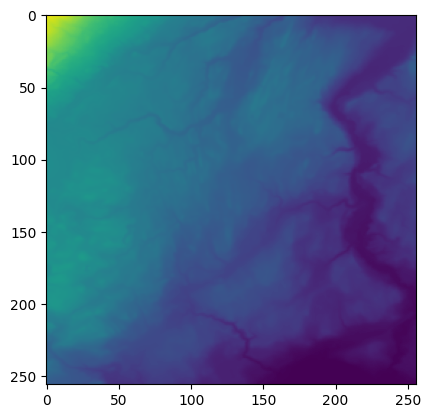

In [72]:
r, m = load_raster('../data/external/altitudes/altitude_venoge_repr.tif', False)
plt.imshow(r)#, cmap='terrain')

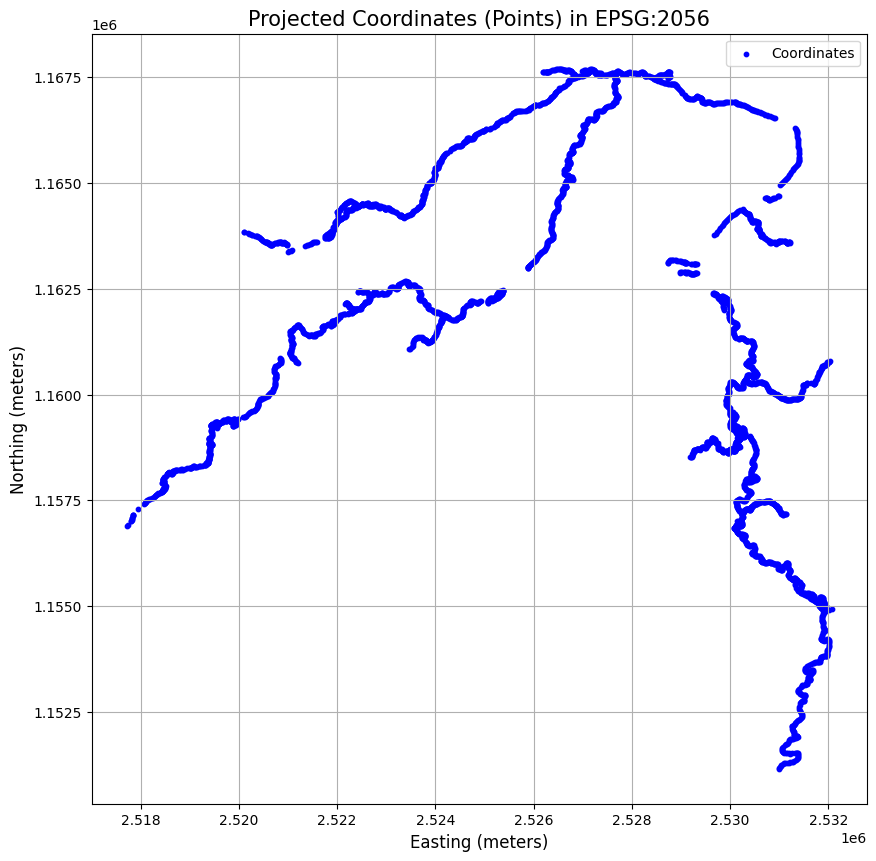

2521968.1356000006 1164037.9024999999


In [116]:
x, y , z= project_linestrings_to_points(gdf_filtered)
print(x[0],y[0])

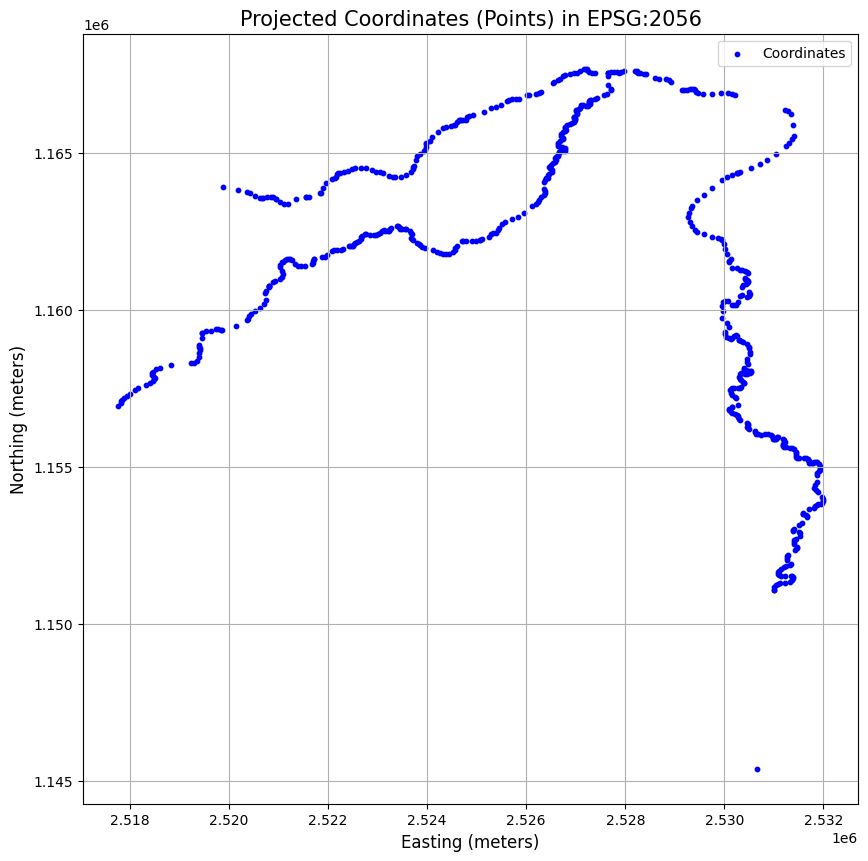

2525075.0 1162205.0


In [68]:
x, y , z= project_linestrings_to_points(rivers['LaVenoge_shapefile'])
print(x[0],y[0])

In [110]:
r, m = load_raster('../data/external/altitudes/altitude_venoge2.tif', False)

In [114]:
lon, lat = 2521545.0, 1163605.0

print("CRS del archivo:", m.crs)
    
# Convertir las coordenadas (lon, lat) en índices de fila y columna del raster
row, col = m.index(lon, lat)
print(f"Índice de la fila: {row}, índice de la columna: {col}")

# Leer el valor del píxel en esa posición
pixel_value = r[row, col]
print(f"Valor del píxel en las coordenadas ({lon}, {lat}): {pixel_value}")

CRS del archivo: LOCAL_CS["CH1903+ / LV95",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Índice de la fila: 2197, índice de la columna: 2272
Valor del píxel en las coordenadas (2521545.0, 1163605.0): 657.4981079101562


fent LaVenoge_shapefile


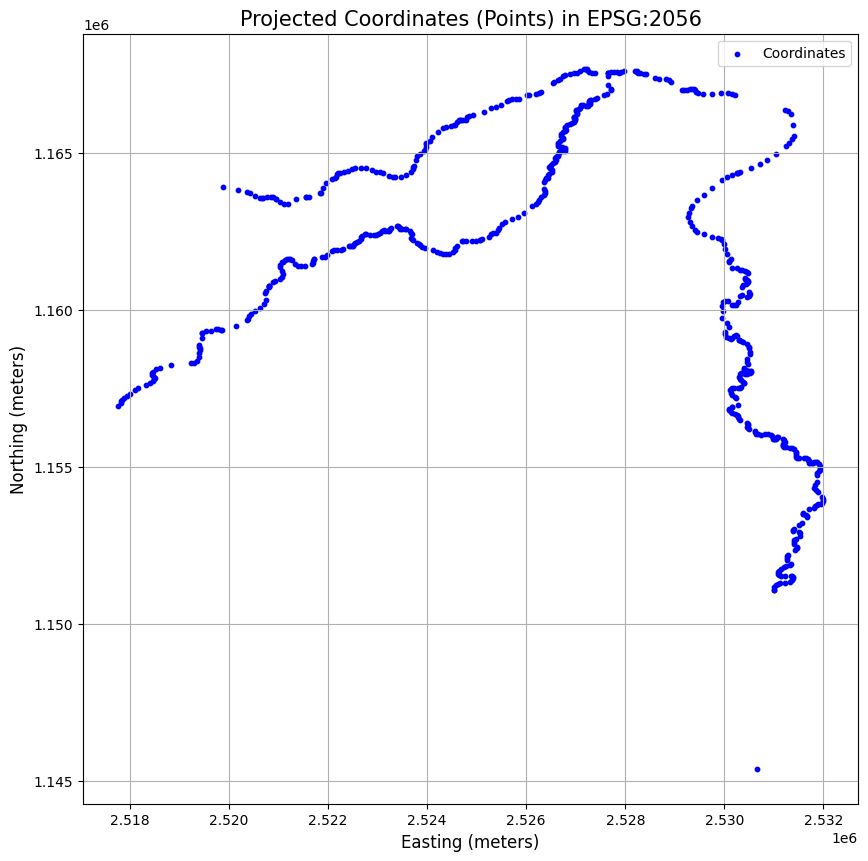

2525075.0 1162205.0
567.64636
2525115.0 1162245.0
568.08374
2525255.0 1162305.0
563.857
2525295.0 1162405.0
564.14594
2525338.4530000016 1162445.3559999987
563.5347
2525395.0 1162445.0
561.183
2525435.0 1162525.0
560.35614
2525455.0 1162605.0
559.32416
2525515.0 1162725.0
561.03265
2525565.0 1162785.0
560.604
2525705.0 1162885.0
556.9207
2525825.0 1162955.0
555.13464
2525965.0 1163085.0
553.0264
2526115.0 1163295.0
551.40015
2526195.0 1163365.0
550.38385
2526235.0 1163425.0
548.8005
2526255.0 1163505.0
548.8972
2526295.0 1163585.0
547.9553
2526355.0 1163645.0
547.137
2526385.0 1163705.0
546.41724
2526385.0 1163765.0
545.6798
2526355.0 1163845.0
545.039
2526355.0 1164065.0
543.9378
2526375.0 1164145.0
540.80194
2526394.4860000014 1164180.4299999997
540.3649
2526431.511 1164201.7190000005
542.175
2526435.745000001 1164290.620000001
539.17566
2526459.028999999 1164326.6030000001
538.6869
2526511.9450000003 1164379.5199999996
540.0137
2526511.9450000003 1164451.4860000014
539.76666
2526497

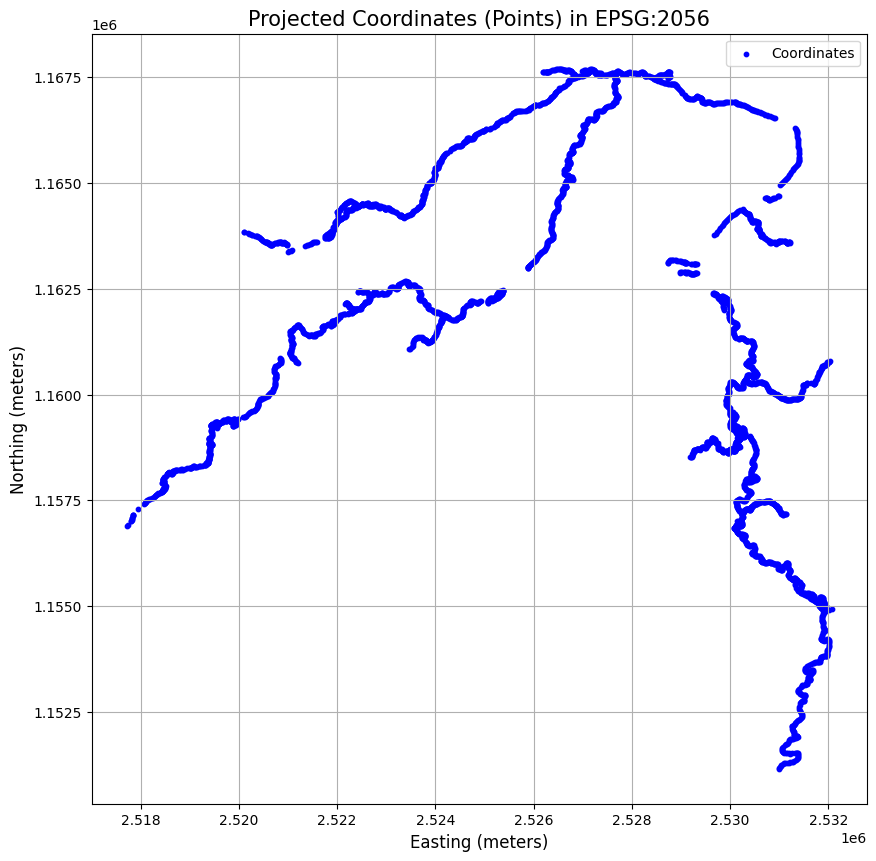

IndexError: index 7533 is out of bounds for axis 1 with size 7500

In [113]:
PATH_DATA = '../data/external/'
for k,river in rivers.items():
    
    print('fent',k)
    x_coords, y_coords, z_coords = project_linestrings_to_points(river)
    
    if z_coords == []:
        dir_altitudes = '../data/external/altitudes'
        if k == 'LaBroye_shapefile':
            file = 'altitude_broye2.tif'
        elif k == 'LaVenoge_shapefile':
            file = 'altitude_venoge2.tif'
        
        r,m = load_raster(f'{dir_altitudes}/{file}', False)
        for i in range(len(x_coords)):
            lon, lat = x_coords[i], y_coords[i]
            print(lon,lat)
            row, col = m.index(lon, lat)
            print(r[row, col])
            z_coords.append(r[row, col])

    projection_coordenates = pd.DataFrame(data={'Coord X': x_coords,'Coord Y': y_coords,'Altitude': z_coords})
    
    
    gdf_filtered = gdf[gdf.intersects(river.unary_union)]
    x_coords_gdf, y_coords_gdf, z_coords_gdf= project_linestrings_to_points(gdf_filtered)

    if z_coords_gdf == []:
        for i in range(len(x_coords_gdf)):
            lon, lat = x_coords_gdf[i], y_coords_gdf[i]
            row, col = m.index(lon, lat)
            z_coords_gdf.append(r[row, col])

    projection_coordenates_filtered = pd.DataFrame(data={'Coord X': x_coords_gdf,'Coord Y': y_coords_gdf,'Altitude': z_coords_gdf})
    # Interpolate the data
    LR = 5.5
    discharge_interpolated = pd.DataFrame(columns=projection_coordenates.index)
    gdf_filtered = gdf_filtered['Discharge']


    for ri,r in gdf_filtered.iterrows():
        temp = pd.concat([pd.DataFrame(r.values, index=r.index, columns=['discharge',]), projection_coordenates_filtered], axis=1)
        
        temp.dropna(inplace=True)

        if len(temp) == 0:
            a = np.empty(projection_coordenates.shape[0])
            a[:] = np.nan
            air_interpolated.loc[ri] = a
        else:
            x = temp['Coord X']
            y = temp['Coord Y']
            z = temp['discharge']

            xi = projection_coordenates['Coord X']
            yi = projection_coordenates['Coord Y']

            discharge_interpolated = simple_idw(x, y, z, xi, yi, beta=2)
            #temp_interpolated -= LR * projection_coordenates['Altitude']  / 1000

            discharge_interpolated.loc[ri] = temp_interpolated

    discharge_interpolated.to_csv(os.path.join(PATH_DATA,f'discharge_interpolated_{k}.csv'), header=True)